# Импорт данных и загрузка данных

Датасет: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import time

In [2]:
# Скачиваем датасет (с правильным именем!)
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")
print("Путь к датасету:", path)

# Показываем все файлы
print("\nФайлы в датасете:")
files = os.listdir(path)
for f in files:
    print(f)

# Пробуем прочитать первый CSV-файл
csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    filename = csv_files[0]
    df = pd.read_csv(os.path.join(path, filename))
    print(f"\nУспешно загружен файл: {filename}")
else:
    print("CSV-файлы не найдены.")

# Нормализация названий столбцов
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

Путь к датасету: /kaggle/input/student-performance-factors

Файлы в датасете:
StudentPerformanceFactors.csv

Успешно загружен файл: StudentPerformanceFactors.csv


# EDA

## Шаг 1: Общая статистика

In [3]:
print(f"Размер датасета: {df.shape}")

Размер датасета: (6607, 20)


Первые 5 строк

In [4]:
df.head()

hours_studied  attendance parental_involvement access_to_resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  extracurricular_activities  sleep_hours  previous_scores motivation_level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  internet_access  tutoring_sessions family_income teacher_quality  \
0             Yes                  0           Low          Medium   
1             Yes                  2        Medium          Medium   
2             Yes                  2        Medium          Medium   
3             Yes                  1        Medium          Medium   
4             Yes                  3        Medium            High   

  school_type peer_influence  physical_activity learning_disabilities  \
0      Public       Positive                  3                    No   
1      Public       Negative                  4                    No   
2      Public        Neutral                  4                    No   
3      Public       Negative                  4                    No   
4      Public        Neutral                  4                    No   

  parental_education_level distance_from_home  gender  exam_score  
0              High School               Near    Male          67  
1                  College           Moderate  Female          61  
2             Postgraduate               Near    Male          74  
3              High School           Moderate    Male          71  
4                  College               Near  Female          70

Типы данных

In [5]:
# df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6607 non-null   int64 
 1   attendance                  6607 non-null   int64 
 2   parental_involvement        6607 non-null   object
 3   access_to_resources         6607 non-null   object
 4   extracurricular_activities  6607 non-null   object
 5   sleep_hours                 6607 non-null   int64 
 6   previous_scores             6607 non-null   int64 
 7   motivation_level            6607 non-null   object
 8   internet_access             6607 non-null   object
 9   tutoring_sessions           6607 non-null   int64 
 10  family_income               6607 non-null   object
 11  teacher_quality             6529 non-null   object
 12  school_type                 6607 non-null   object
 13  peer_influence              6607 non-null   obje

In [6]:
print("\nОбщее количество столбцов:", df.shape[1])


Общее количество столбцов: 20


Описательная статистика по целевому переменному

Вывод:
1. Датасет содержит 6607 строк и 20 столбцов
2. Есть как числовые (int, float), так и категориальные (object) признаки.
3. Признаки включают: возраст, время сна, подготовка, стресс, питание и т.д.

## Шаг 2: Анализ пропусков

In [7]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

Пропуски  Процент
hours_studied                      0     0.00
attendance                         0     0.00
parental_involvement               0     0.00
access_to_resources                0     0.00
extracurricular_activities         0     0.00
sleep_hours                        0     0.00
previous_scores                    0     0.00
motivation_level                   0     0.00
internet_access                    0     0.00
tutoring_sessions                  0     0.00
family_income                      0     0.00
teacher_quality                   78     1.18
school_type                        0     0.00
peer_influence                     0     0.00
physical_activity                  0     0.00
learning_disabilities              0     0.00
parental_education_level          90     1.36
distance_from_home                67     1.01
gender                             0     0.00
exam_score                         0     0.00

                          Пропуски  Процент
teacher_quality                 78     1.18
parental_education_level        90     1.36
distance_from_home              67     1.01


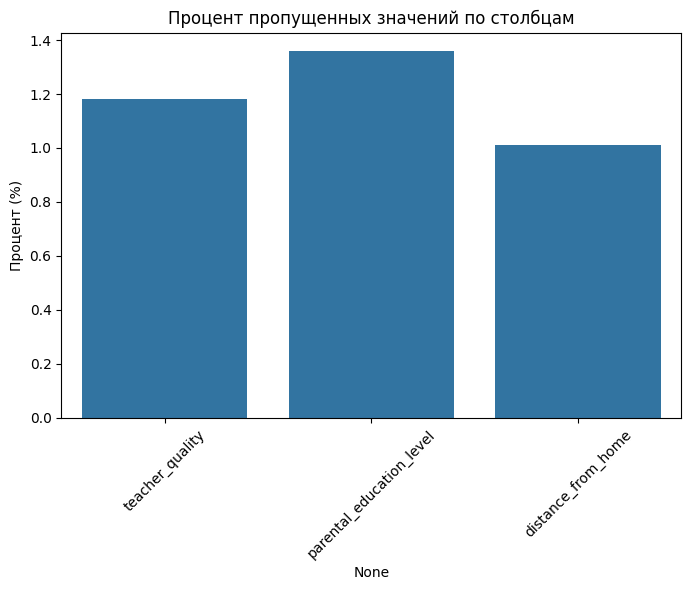

In [8]:
missing_df = missing_df[missing_df['Пропуски'] > 0]

if missing_df.empty:
    print("❌ Пропущенных значений нет.")
else:
    print(missing_df)
    # Визуализация
    plt.figure(figsize=(8, 5))
    sns.barplot(x=missing_df.index, y=missing_df['Процент'])
    plt.title("Процент пропущенных значений по столбцам")
    plt.ylabel("Процент (%)")
    plt.xticks(rotation=45)
    plt.show()

Вывод:
1. Есть пропуски
2. Пропусков мало

## Шаг 3. Анализ дубликатов

In [9]:
duplicates = df.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

Количество дубликатов: 0


## Шаг 4: Поиск выбросов (IQR)

                   count  percent
hours_studied       43.0     0.65
attendance           0.0     0.00
sleep_hours          0.0     0.00
previous_scores      0.0     0.00
tutoring_sessions  430.0     6.51
physical_activity    0.0     0.00
exam_score         104.0     1.57


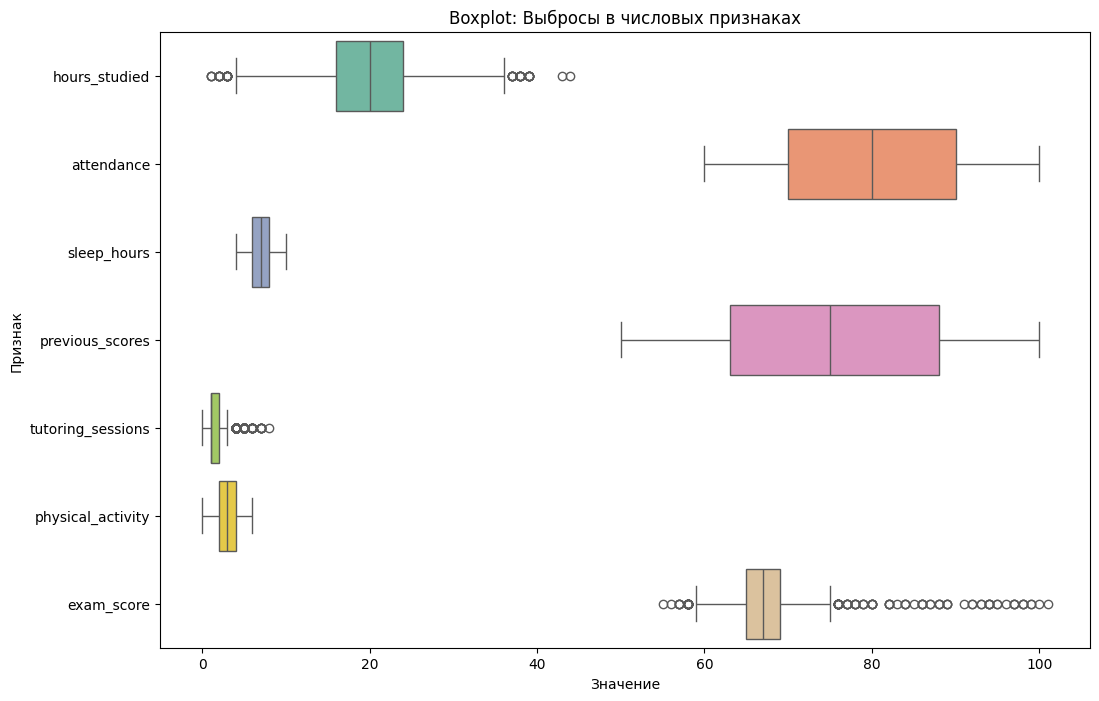

In [12]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Используем IQR для выявления выбросов
outliers_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outliers_summary[col] = {
        'count': outlier_count,
        'percent': (outlier_count / len(df)) * 100
    }

# Вывод
outliers_df = pd.DataFrame(outliers_summary).T
print(outliers_df[['count', 'percent']].round(2))

# Визуализация выбросов (boxplot)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_cols], orient="h", palette="Set2")
plt.title("Boxplot: Выбросы в числовых признаках")
plt.xlabel("Значение")
plt.ylabel("Признак")
plt.show()

Интересно!!!

In [13]:
df[df['exam_score'] > 95].sort_values('exam_score', ascending=False)

hours_studied  attendance parental_involvement access_to_resources  \
1525             27          98                  Low              Medium   
94               18          89                 High              Medium   
2425             23          83                 High                High   
3579             14          90                 High                High   
6347             28          96                 High                 Low   
6393             16          83                  Low              Medium   
4192             28          90                  Low              Medium   
919              21          74                 High              Medium   
529              15          83               Medium              Medium   
5966             25          99               Medium              Medium   
3457             18          93               Medium              Medium   

     extracurricular_activities  sleep_hours  previous_scores  \
1525                        Yes            6               93   
94                          Yes            4               73   
2425                        Yes            4               89   
3579                        Yes            8               86   
6347                        Yes            4               98   
6393                        Yes            8               92   
4192                        Yes            9               91   
919                          No            6               94   
529                          No            7               97   
5966                        Yes            7               77   
3457                         No            7               76   

     motivation_level internet_access  tutoring_sessions family_income  \
1525              Low              No                  5          High   
94             Medium             Yes                  3          High   
2425              Low             Yes                  1        Medium   
3579           Medium             Yes                  4        Medium   
6347             High             Yes                  1          High   
6393              Low             Yes                  2          High   
4192           Medium             Yes                  0        Medium   
919            Medium             Yes                  1           Low   
529            Medium             Yes                  2           Low   
5966           Medium             Yes                  0          High   
3457              Low             Yes                  2        Medium   

     teacher_quality school_type peer_influence  physical_activity  \
1525            High      Public       Positive                  3   
94            Medium     Private       Positive                  2   
2425          Medium      Public       Negative                  3   
3579          Medium     Private       Negative                  2   
6347            High      Public       Positive                  3   
6393            High      Public       Positive                  4   
4192          Medium      Public       Positive                  2   
919             High      Public       Positive                  1   
529             High     Private        Neutral                  2   
5966            High      Public        Neutral                  3   
3457          Medium     Private        Neutral                  4   

     learning_disabilities parental_education_level distance_from_home  \
1525                    No              High School           Moderate   
94                      No                  College               Near   
2425                    No              High School                Far   
3579                    No              High School               Near   
6347                    No              High School               Near   
6393                    No             Postgraduate               Near   
4192                    No                  College           Mo

In [14]:
df[df['exam_score'] > 100]

hours_studied  attendance parental_involvement access_to_resources  \
1525             27          98                  Low              Medium   

     extracurricular_activities  sleep_hours  previous_scores  \
1525                        Yes            6               93   

     motivation_level internet_access  tutoring_sessions family_income  \
1525              Low              No                  5          High   

     teacher_quality school_type peer_influence  physical_activity  \
1525            High      Public       Positive                  3   

     learning_disabilities parental_education_level distance_from_home  \
1525                    No              High School           Moderate   

      gender  exam_score  
1525  Female         101

Вывод:
1. Три признака имеют выбросы
2. Признак:
	- hours_studied (количество потраченных часов на обучение): могут иметь выбросы, потому что люди все люди по разному обучаются
	- tutoring_sessions (количество посещаемых репетиторских занятий в месяц): тоже могут быть выбросы, потому что кто-то посещает репетитора, а кто-то нет
	- exam_score (оценка за экзамен): тоже понятно, больше людей получает средний результ, а несколько высокие оценки

## Шаг 5: Анализ целевой переменной

Описательная статистика по целевому переменному

In [15]:
df['exam_score'].describe()

count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: exam_score, dtype: float64

Целевая переменная — Exam_Score (число от 55 до 101). 101 - это скорее выброс

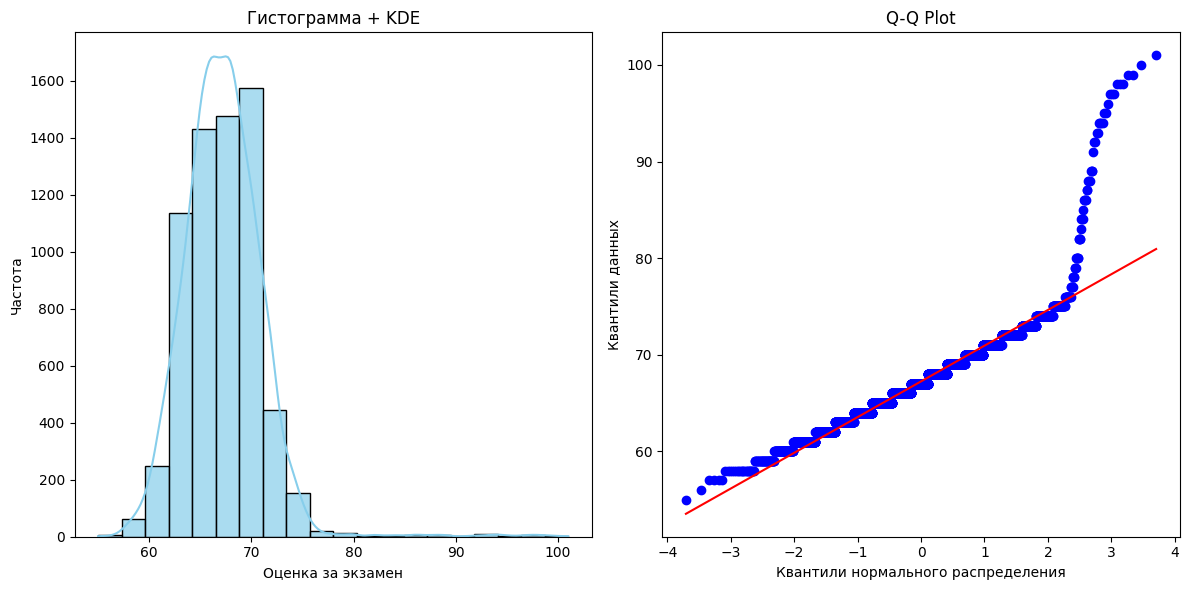

In [16]:
# Данные
data = df['exam_score'].dropna()

# Создание фигуры с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Левый график: Гистограмма + KDE
sns.histplot(data, bins=20, kde=True, color='skyblue', alpha=0.7, ax=ax1)
ax1.set_title('Гистограмма + KDE')
ax1.set_xlabel('Оценка за экзамен')
ax1.set_ylabel('Частота')

# Правый график: Q-Q Plot
stats.probplot(data, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot')
ax2.set_xlabel('Квантили нормального распределения')
ax2.set_ylabel('Квантили данных')

# Улучшаем отображение
plt.tight_layout()
plt.show()

1. Асимметричная (перекос) целевой переменной
2. Отклонения — указывают на асимметрию или тяжёлые хвосты, данные хвосты были объяснены на шаге 4

## Шаг 6: Анализ признаков

In [17]:
# Разделим признаки на числовые и категориальные
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые признаки: {numeric_cols}")
print(f"Категориальные признаки: {categorical_cols}")

Числовые признаки: ['hours_studied', 'attendance', 'sleep_hours', 'previous_scores', 'tutoring_sessions', 'physical_activity', 'exam_score']
Категориальные признаки: ['parental_involvement', 'access_to_resources', 'extracurricular_activities', 'motivation_level', 'internet_access', 'family_income', 'teacher_quality', 'school_type', 'peer_influence', 'learning_disabilities', 'parental_education_level', 'distance_from_home', 'gender']


### Одномерный анализ

#### Анализ категориальных признаков


🔍 Признак: parental_involvement
Уникальные значения: ['Low' 'Medium' 'High']
Частота значений:
parental_involvement
Medium    3362
High      1908
Low       1337
Name: count, dtype: int64

Описание:
count       6607
unique         3
top       Medium
freq        3362
Name: parental_involvement, dtype: object


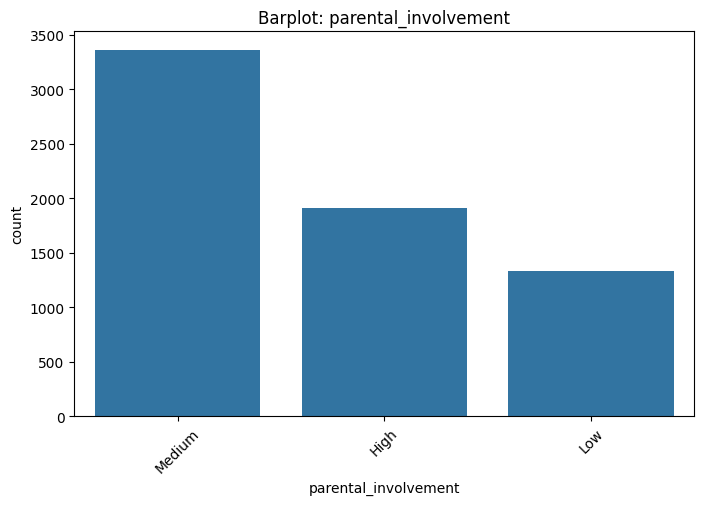


🔍 Признак: access_to_resources
Уникальные значения: ['High' 'Medium' 'Low']
Частота значений:
access_to_resources
Medium    3319
High      1975
Low       1313
Name: count, dtype: int64

Описание:
count       6607
unique         3
top       Medium
freq        3319
Name: access_to_resources, dtype: object


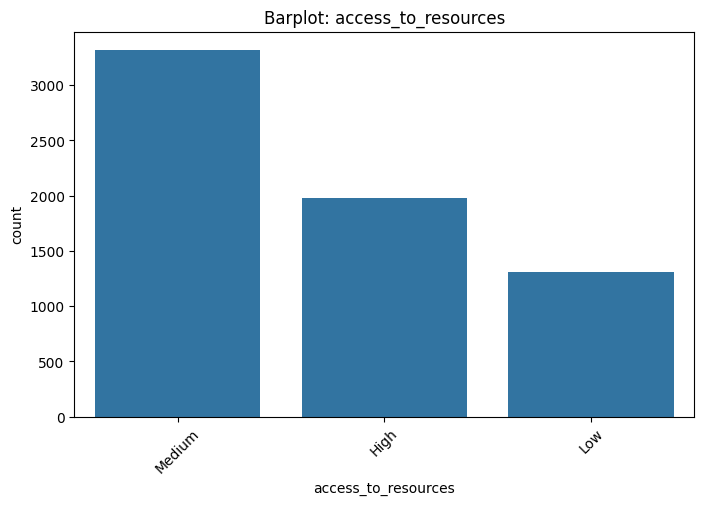


🔍 Признак: extracurricular_activities
Уникальные значения: ['No' 'Yes']
Частота значений:
extracurricular_activities
Yes    3938
No     2669
Name: count, dtype: int64

Описание:
count     6607
unique       2
top        Yes
freq      3938
Name: extracurricular_activities, dtype: object


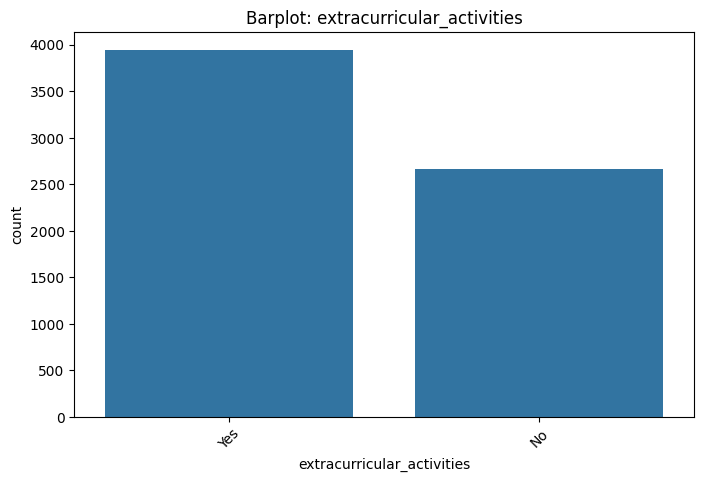


🔍 Признак: motivation_level
Уникальные значения: ['Low' 'Medium' 'High']
Частота значений:
motivation_level
Medium    3351
Low       1937
High      1319
Name: count, dtype: int64

Описание:
count       6607
unique         3
top       Medium
freq        3351
Name: motivation_level, dtype: object


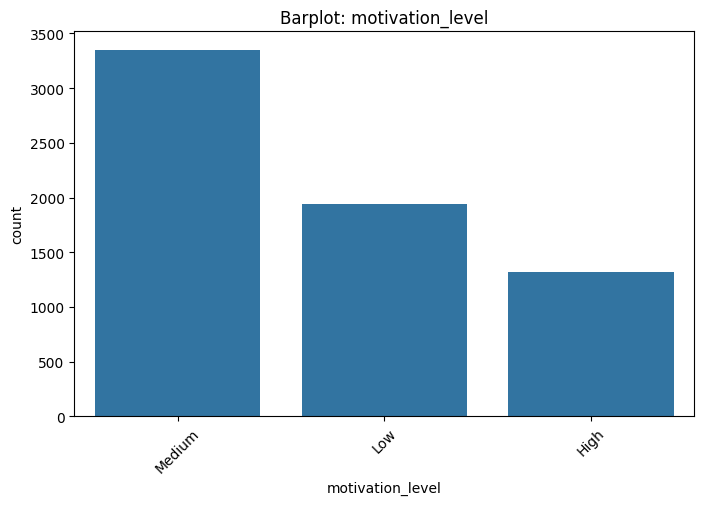


🔍 Признак: internet_access
Уникальные значения: ['Yes' 'No']
Частота значений:
internet_access
Yes    6108
No      499
Name: count, dtype: int64

Описание:
count     6607
unique       2
top        Yes
freq      6108
Name: internet_access, dtype: object


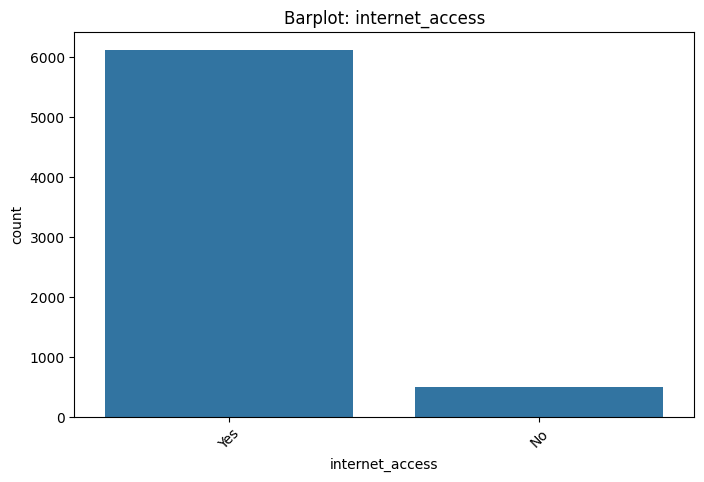


🔍 Признак: family_income
Уникальные значения: ['Low' 'Medium' 'High']
Частота значений:
family_income
Low       2672
Medium    2666
High      1269
Name: count, dtype: int64

Описание:
count     6607
unique       3
top        Low
freq      2672
Name: family_income, dtype: object


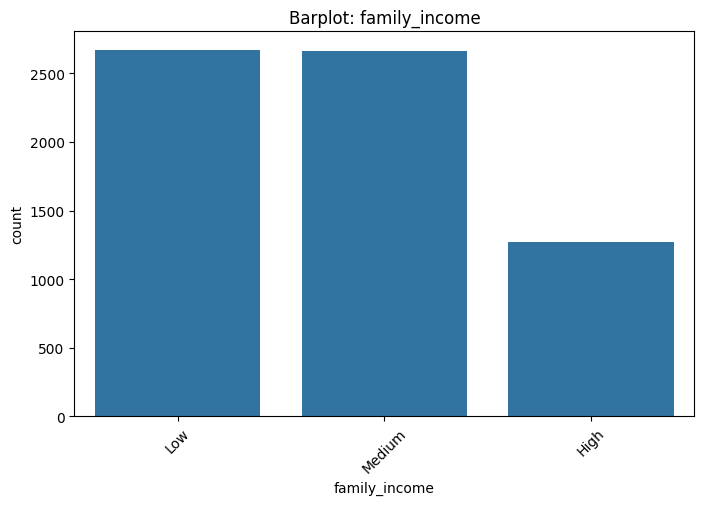


🔍 Признак: teacher_quality
Уникальные значения: ['Medium' 'High' 'Low' nan]
Частота значений:
teacher_quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64

Описание:
count       6529
unique         3
top       Medium
freq        3925
Name: teacher_quality, dtype: object


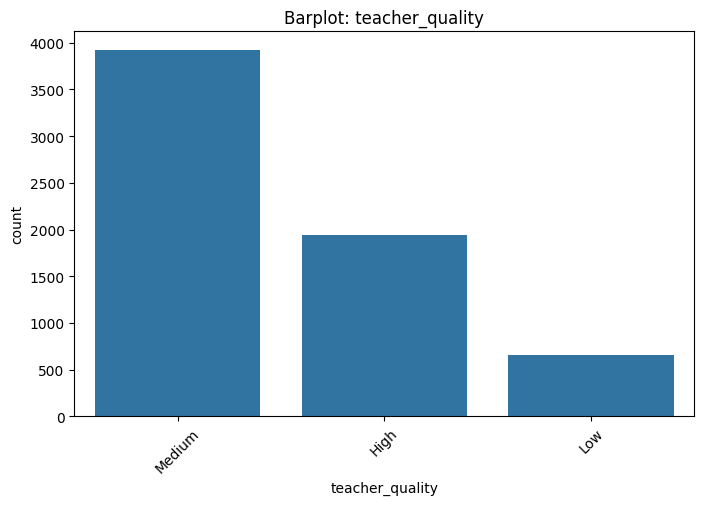


🔍 Признак: school_type
Уникальные значения: ['Public' 'Private']
Частота значений:
school_type
Public     4598
Private    2009
Name: count, dtype: int64

Описание:
count       6607
unique         2
top       Public
freq        4598
Name: school_type, dtype: object


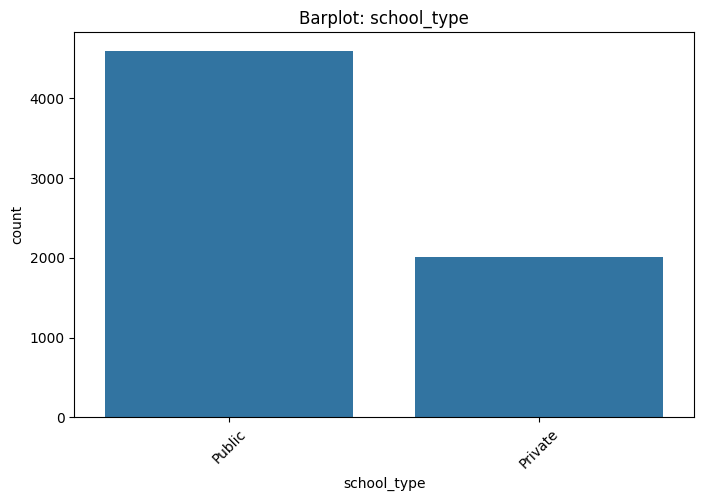


🔍 Признак: peer_influence
Уникальные значения: ['Positive' 'Negative' 'Neutral']
Частота значений:
peer_influence
Positive    2638
Neutral     2592
Negative    1377
Name: count, dtype: int64

Описание:
count         6607
unique           3
top       Positive
freq          2638
Name: peer_influence, dtype: object


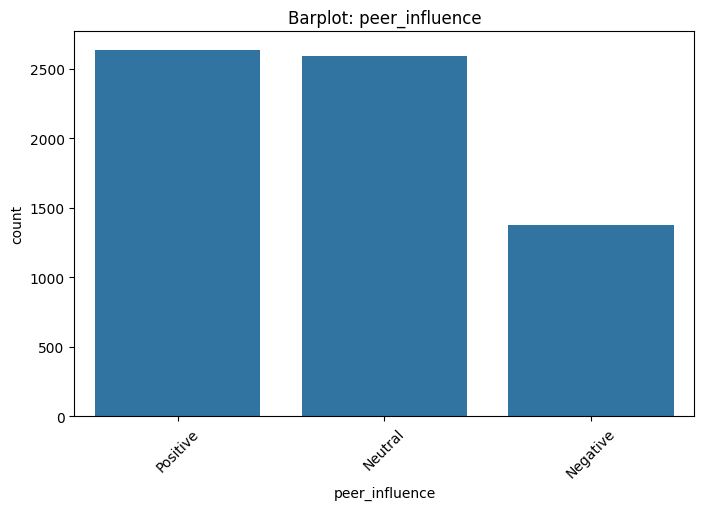


🔍 Признак: learning_disabilities
Уникальные значения: ['No' 'Yes']
Частота значений:
learning_disabilities
No     5912
Yes     695
Name: count, dtype: int64

Описание:
count     6607
unique       2
top         No
freq      5912
Name: learning_disabilities, dtype: object


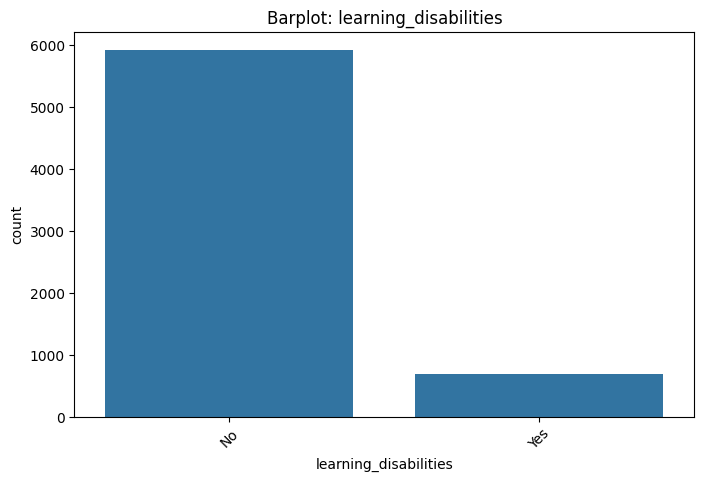


🔍 Признак: parental_education_level
Уникальные значения: ['High School' 'College' 'Postgraduate' nan]
Частота значений:
parental_education_level
High School     3223
College         1989
Postgraduate    1305
Name: count, dtype: int64

Описание:
count            6517
unique              3
top       High School
freq             3223
Name: parental_education_level, dtype: object


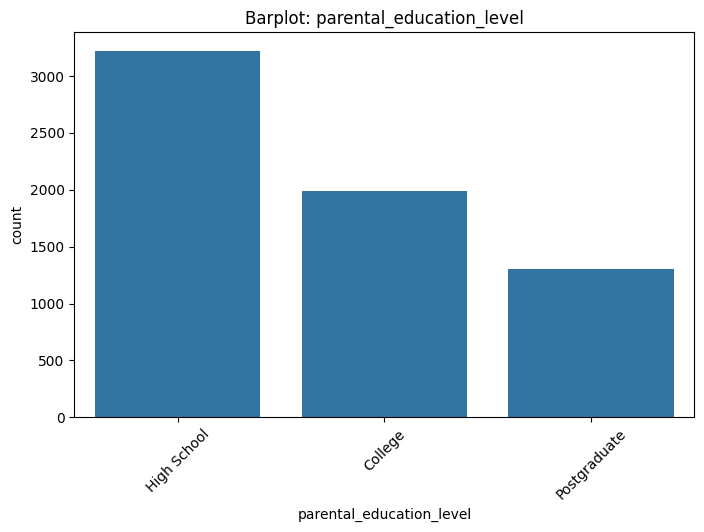


🔍 Признак: distance_from_home
Уникальные значения: ['Near' 'Moderate' 'Far' nan]
Частота значений:
distance_from_home
Near        3884
Moderate    1998
Far          658
Name: count, dtype: int64

Описание:
count     6540
unique       3
top       Near
freq      3884
Name: distance_from_home, dtype: object


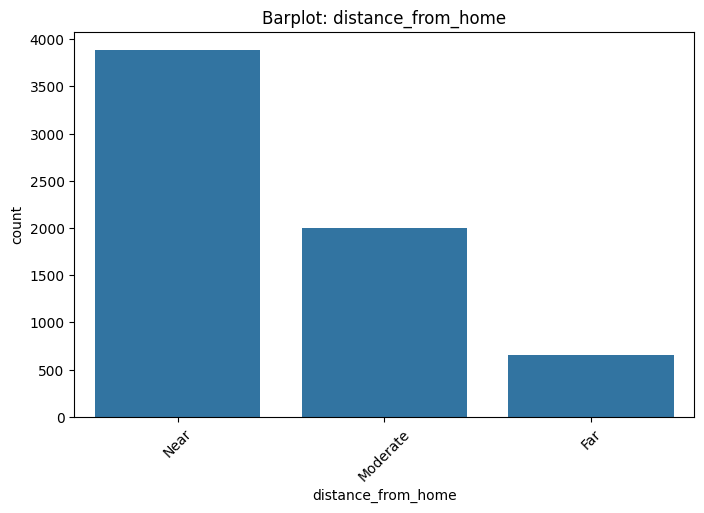


🔍 Признак: gender
Уникальные значения: ['Male' 'Female']
Частота значений:
gender
Male      3814
Female    2793
Name: count, dtype: int64

Описание:
count     6607
unique       2
top       Male
freq      3814
Name: gender, dtype: object


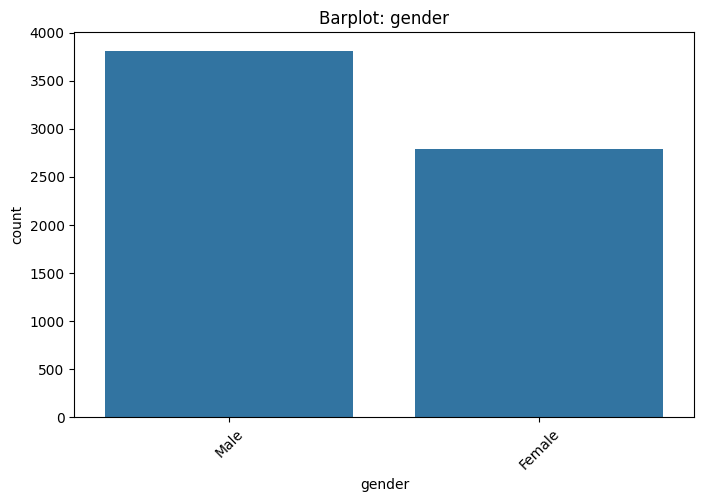

In [18]:
for col in categorical_cols:
    print(f"\n🔍 Признак: {col}")

    # .unique() и .value_counts()
    unique_values = df[col].unique()
    value_counts = df[col].value_counts()

    print(f"Уникальные значения: {unique_values}")
    print(f"Частота значений:\n{value_counts}")

    # df.describe()
    print(f"\nОписание:")
    print(df[col].describe())

    # Barplot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, order=value_counts.index)
    plt.title(f'Barplot: {col}')
    plt.xticks(rotation=45)
    plt.show()

Вывод:
1. Практически все категориальные переменные имеют распределение Low, Medium, High их буду менять LabelEncoder, потому что считаю High имеет более высокий шанс получения высоких результатов. Некоторые имеют бинарное распределение и для них OneHotEncoder, но есть исключения
2. LabelEncoder('Low' 'Medium' 'High'):
	- parental_involvement
	- access_to_resources
	- family_income

4. LabelEncoder('No' 'Yes'):
	- extracurricular_activities (внекласное обучение)
	- internet_access (доступ к интернету)
	- learning_disabilities

5. LabelEncoder('Positive' 'Negative' 'Neutral'):
	- peer_influence

6. LabelEncoder('High School' 'College' 'Postgraduate'):
	- parental_education_level

7. LabelEncoder('Near' 'Moderate' 'Far'):
	- distance_from_home

6. OneHotEncoder:
  - school_type
  - gender
  - motivation_level
  - teacher_quality

8. Пропуски:
	- teacher_quality: пока не понимаю, что делать с данными пропусками, возможзно создать 4 пункт. Unknown
	- parental_education_level: 4 пункт Unknown
	- distance_from_home: 4 пункт Unknown

#### Анализ количественных признаков


🔍 Признак: hours_studied
Описательная статистика:
count    6607.000000
mean       19.975329
std         5.990594
min         1.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        44.000000
Name: hours_studied, dtype: float64


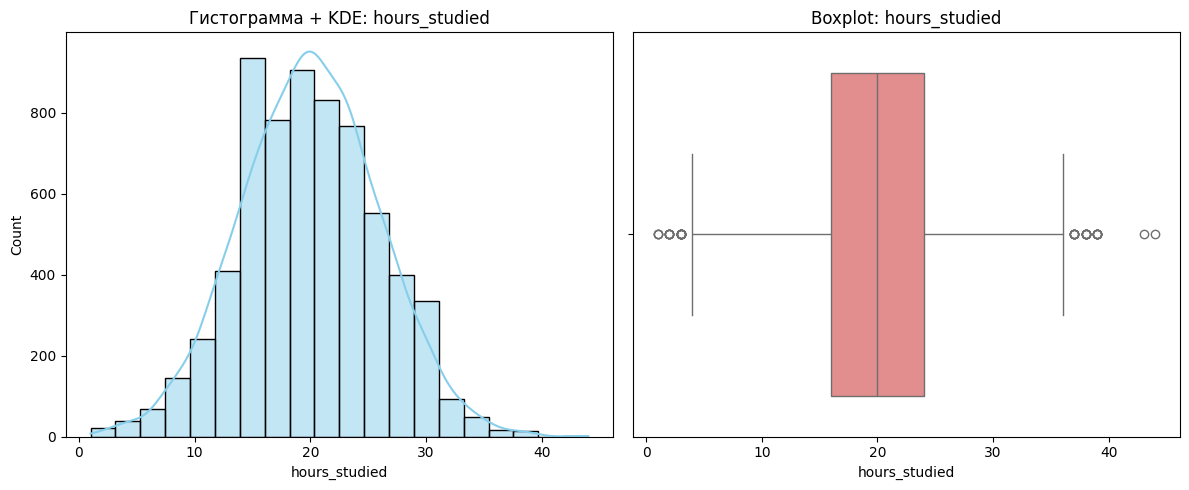


🔍 Признак: attendance
Описательная статистика:
count    6607.000000
mean       79.977448
std        11.547475
min        60.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: attendance, dtype: float64


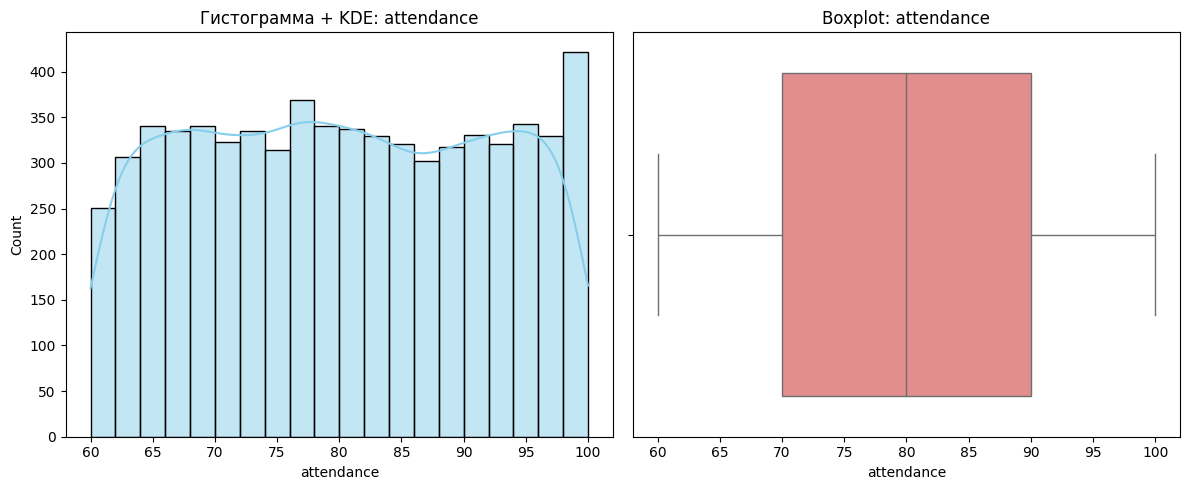


🔍 Признак: sleep_hours
Описательная статистика:
count    6607.00000
mean        7.02906
std         1.46812
min         4.00000
25%         6.00000
50%         7.00000
75%         8.00000
max        10.00000
Name: sleep_hours, dtype: float64


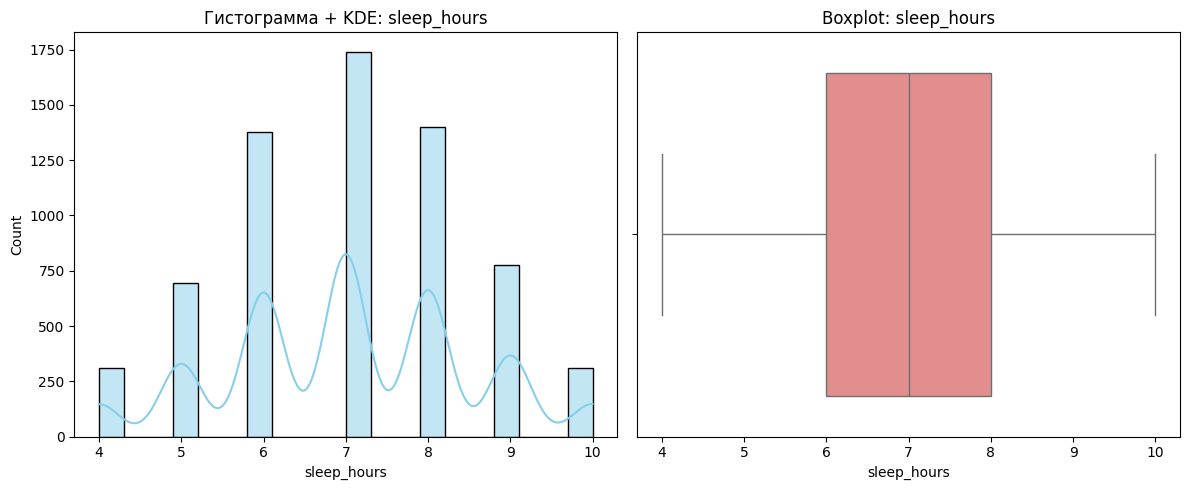


🔍 Признак: previous_scores
Описательная статистика:
count    6607.000000
mean       75.070531
std        14.399784
min        50.000000
25%        63.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: previous_scores, dtype: float64


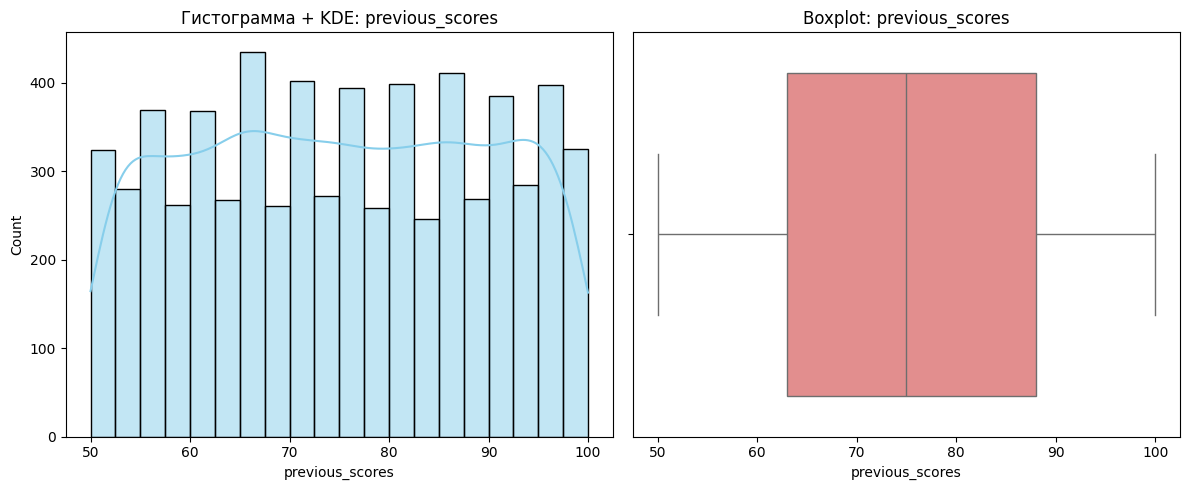


🔍 Признак: tutoring_sessions
Описательная статистика:
count    6607.000000
mean        1.493719
std         1.230570
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: tutoring_sessions, dtype: float64


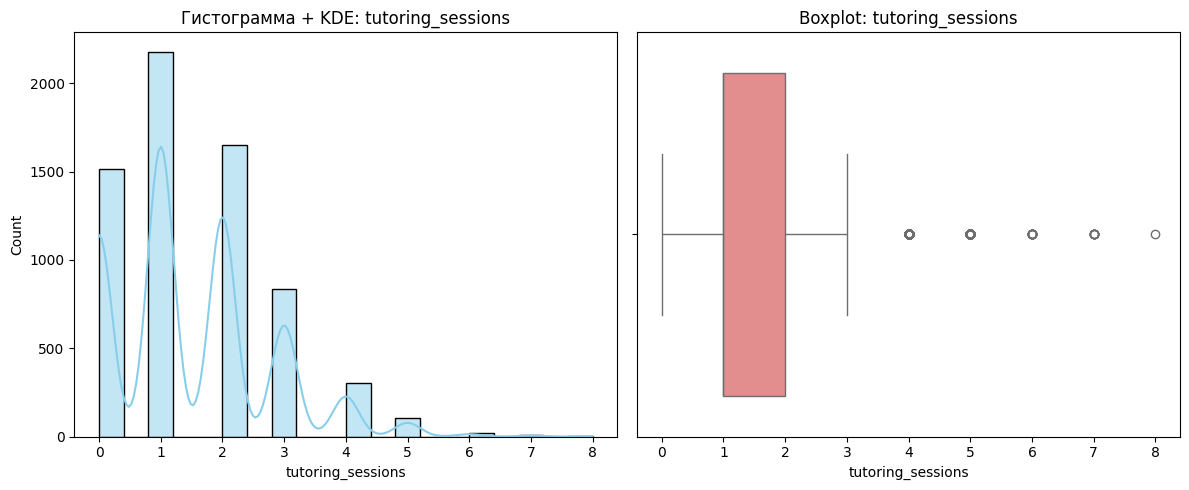


🔍 Признак: physical_activity
Описательная статистика:
count    6607.000000
mean        2.967610
std         1.031231
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: physical_activity, dtype: float64


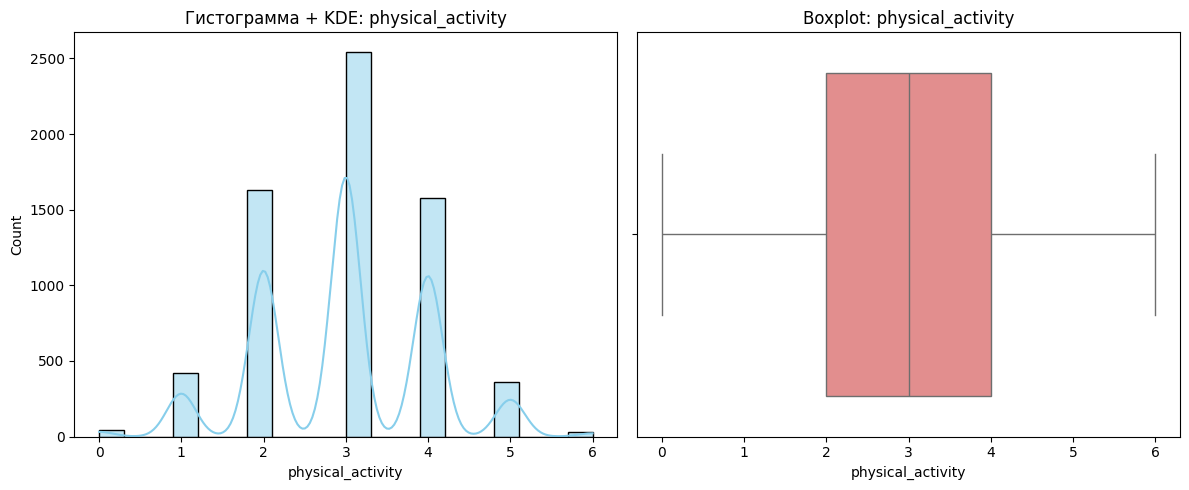


🔍 Признак: exam_score
Описательная статистика:
count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: exam_score, dtype: float64


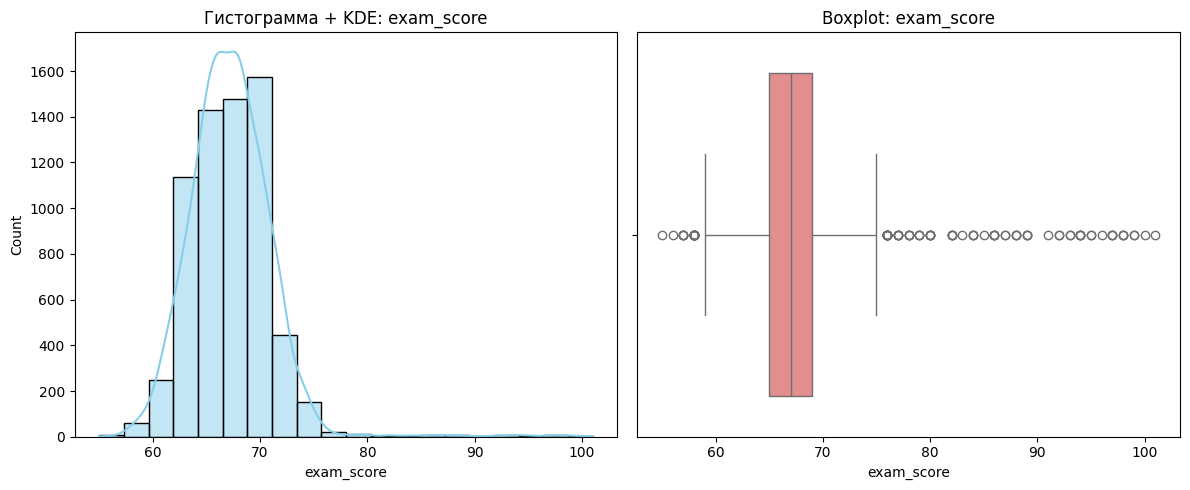

In [19]:
for col in numeric_cols:
    print(f"\n🔍 Признак: {col}")

    # df.describe()
    print(f"Описательная статистика:")
    print(df[col].describe())

    # Гистограмма + плотность
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Гистограмма + KDE: {col}')
    plt.xlabel(col)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

Вывод:
1. hours_studied: данные распеределены нормально, есть выбросы. Но можно их оставить, потому что есть люди, которые мало обучаются
2. attendance: распределение равномерное
3. sleep_hours: есть люди, которые спят 4-6 или 10-12 неизвестно, они спят так постоянно или только перед экзаменамиэ
4. previous_scores: распределение равномерное
5. tutoring_sessions: имеет ассиметричное распределение. Это нормально, потому что некоторые много посещают репетиторов
6. physical_activity: нормальное распределение
7. exam_score: новые результаты уже неимеют равномерное распеределение и есть выбросы

### Двумерный анализ

#### Признак и Целевая переменная (Два числовых)

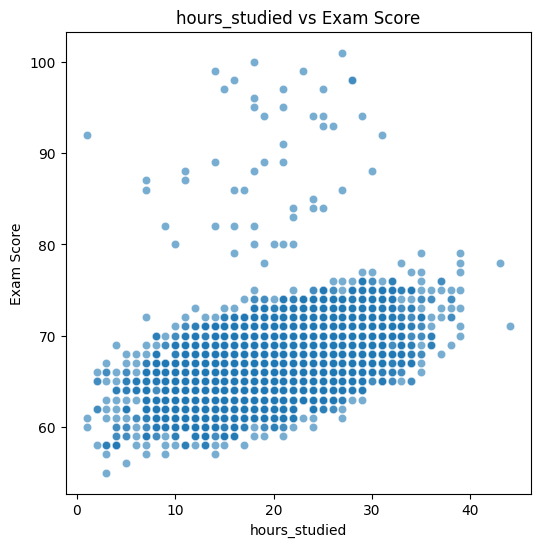

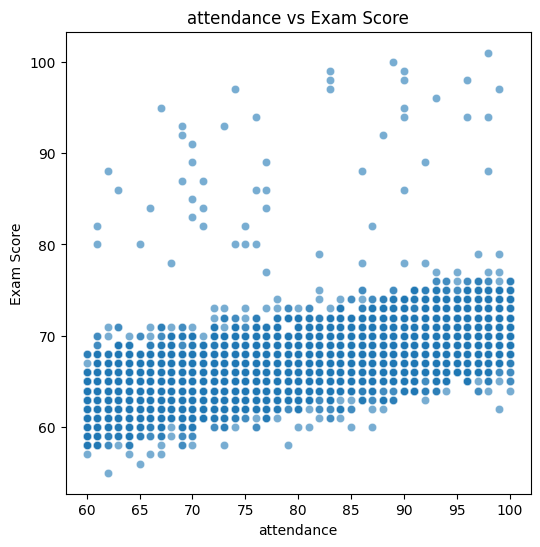

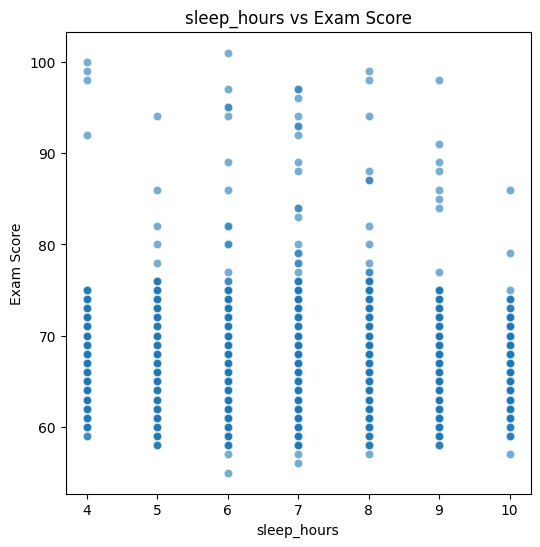

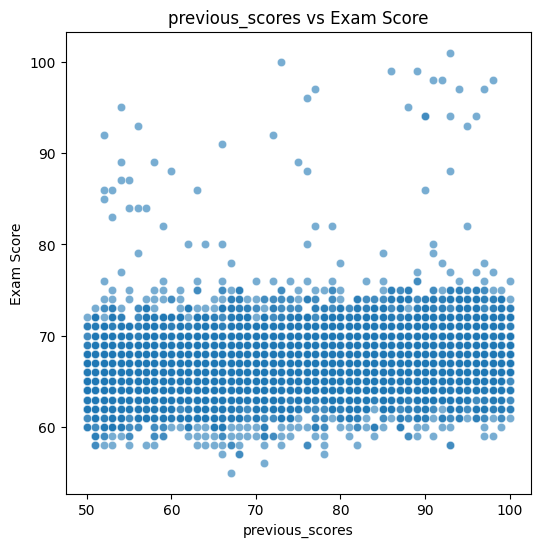

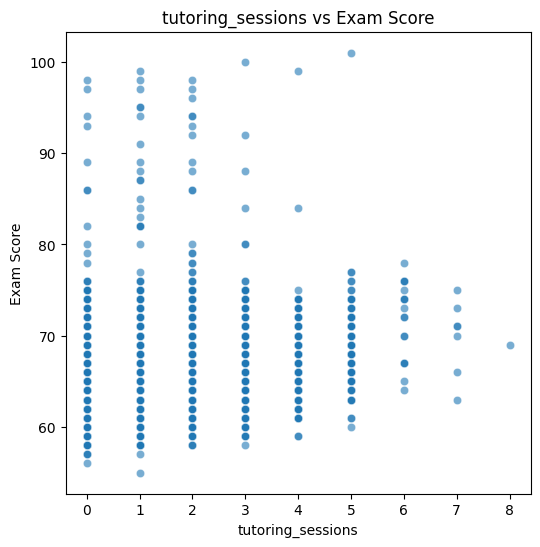

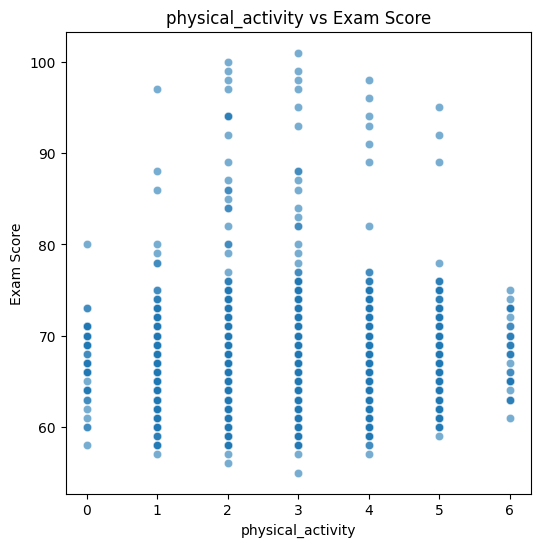

In [20]:
# Числовой vs Целевая переменная
for col in numeric_cols:
    if col != 'exam_score':
        plt.figure(figsize=(6, 6))
        sns.scatterplot(data=df, x=col, y='exam_score', alpha=0.6)
        plt.title(f'{col} vs Exam Score')
        plt.xlabel(col)
        plt.ylabel('Exam Score')
        plt.show()

Вывод:
1. Hours_Studied: Есть выбросы. По хорошему их надо расматривать по отдельности
2. Attendance: Большинство обучающихся мало посещают занятия, но есть линейная зависимость между посещаемостью и оценкой
3. Sleep_Hours: Есть люди, которые спят по 4 и 6 и получили самый высокий балл. Кто это?
4. Previous_Scores: Большинство из тех кто получил хороший балл предыдущий раз. Получили низкий балл
5. Tutoring_Sessions: Те кто мало обучается, лучше резултаты. Это скорее они много отдыхают
6. Физическая активность влияет на обучение. Чем меньше или больше, тем хуже

#### Признак (категориальный) и Целевая переменная

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


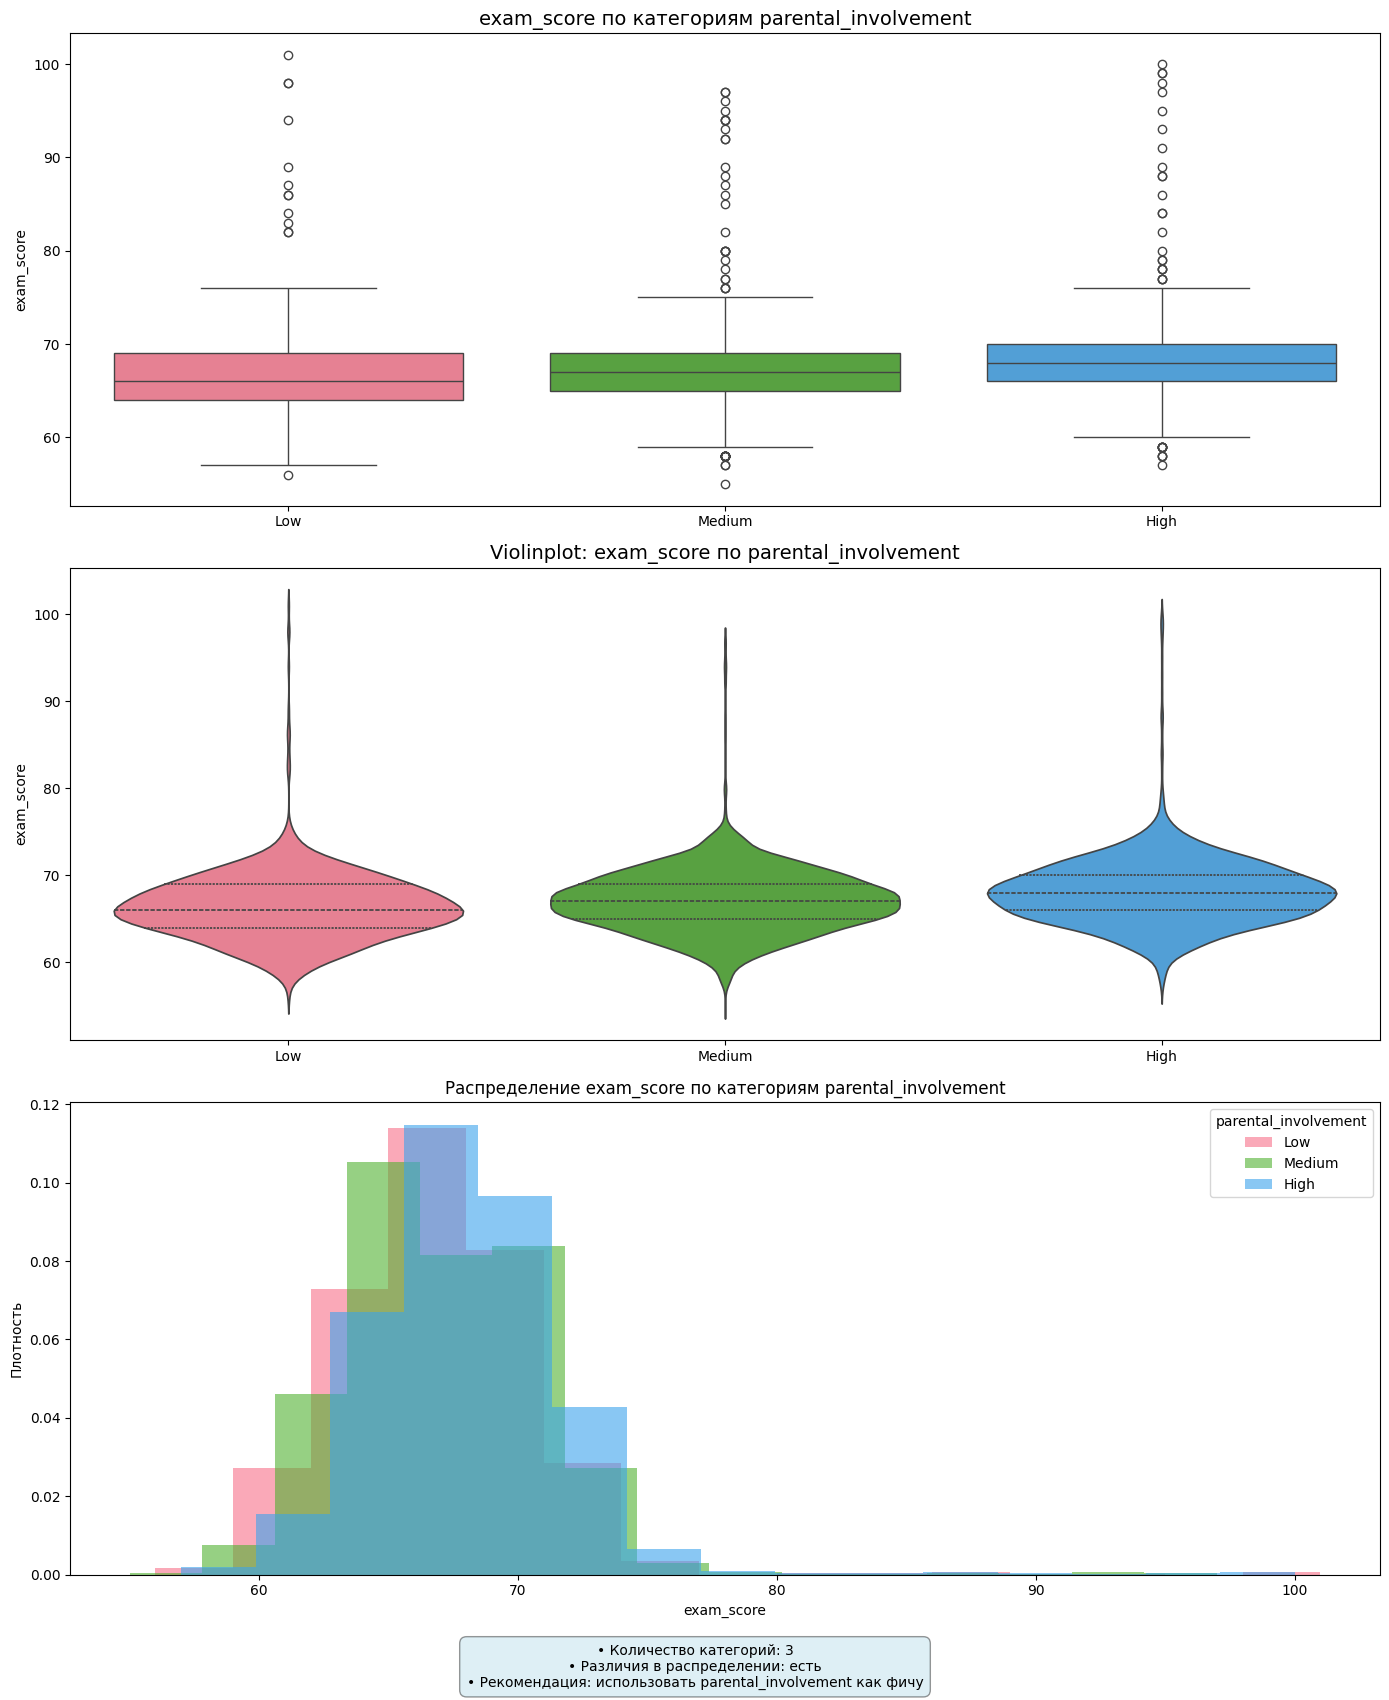

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


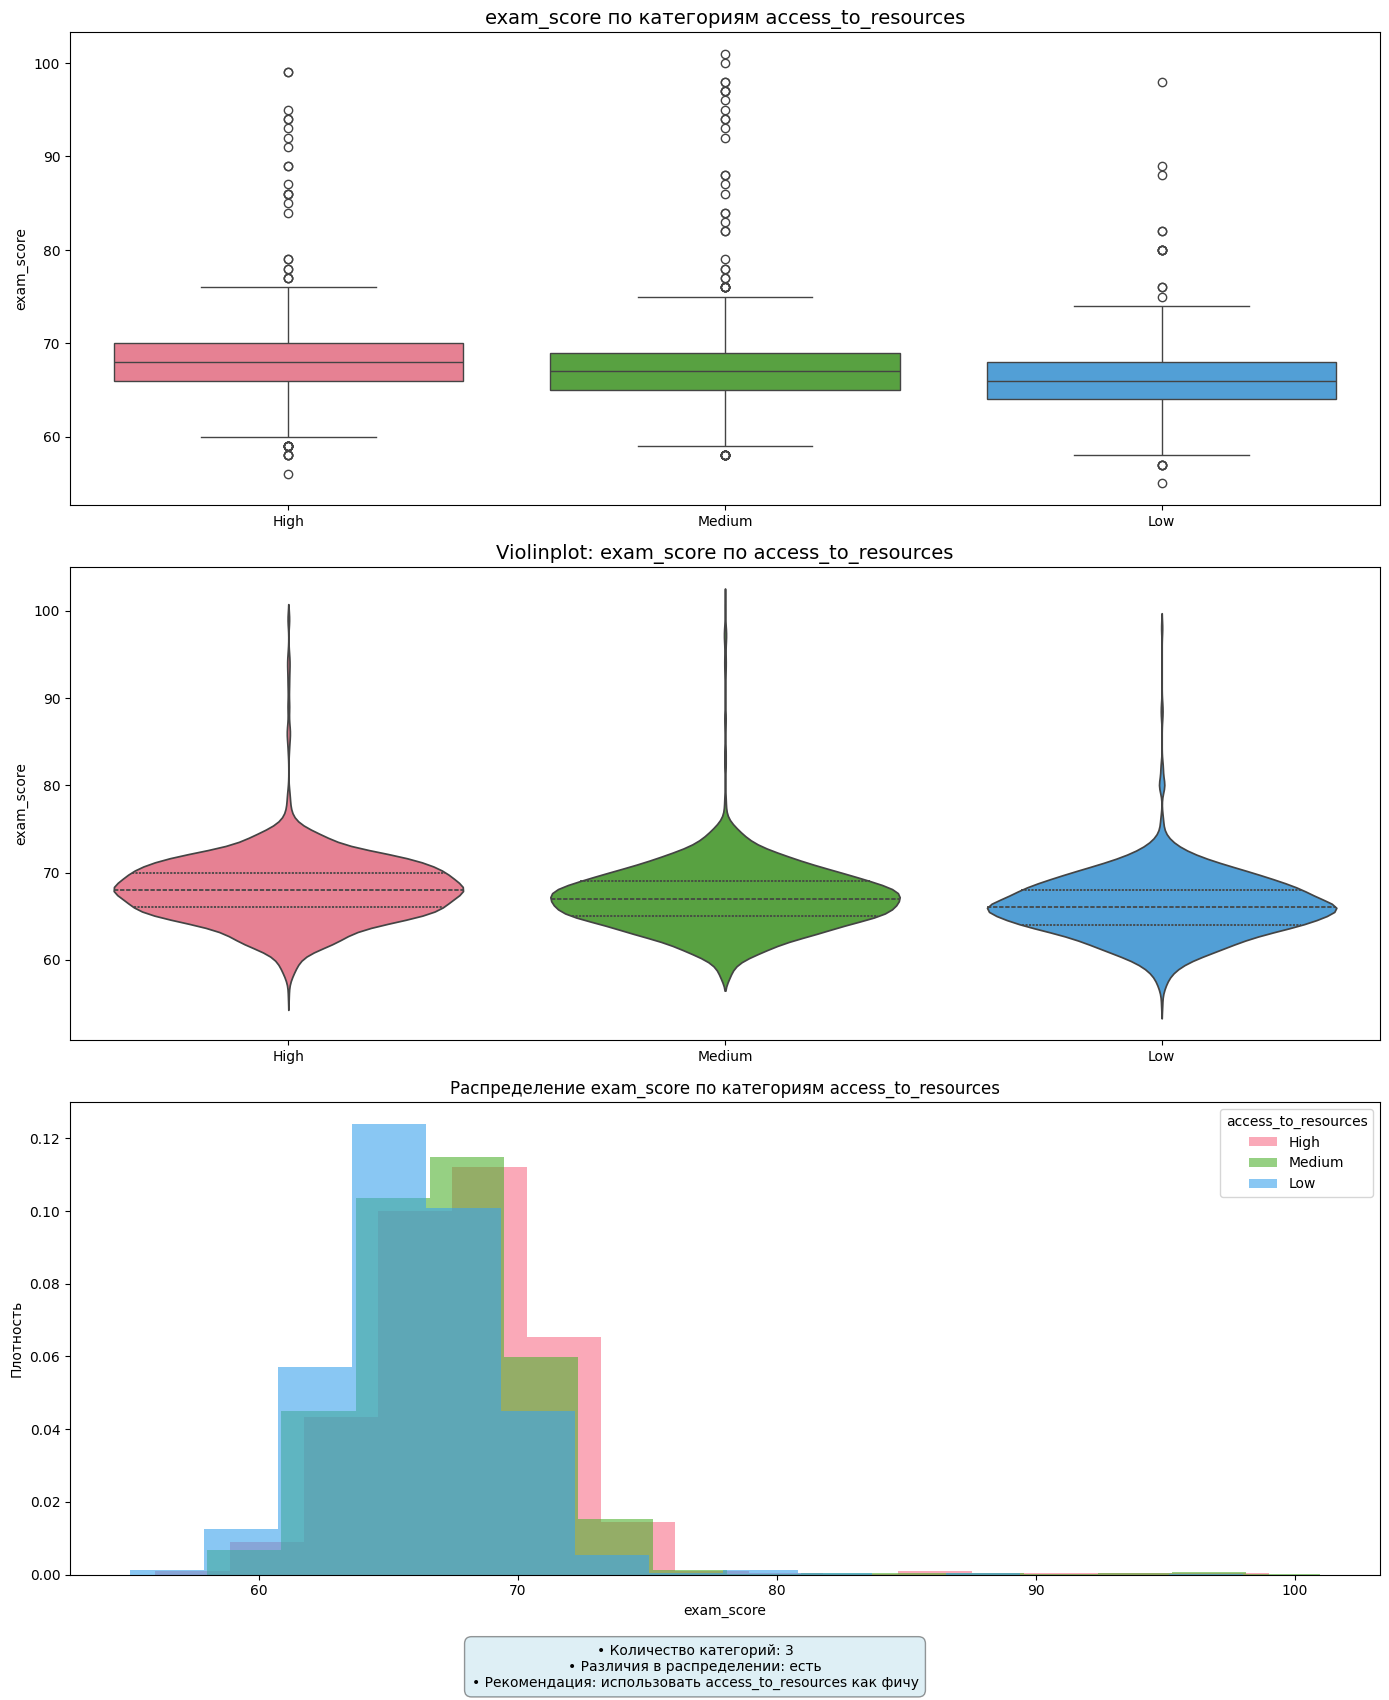

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


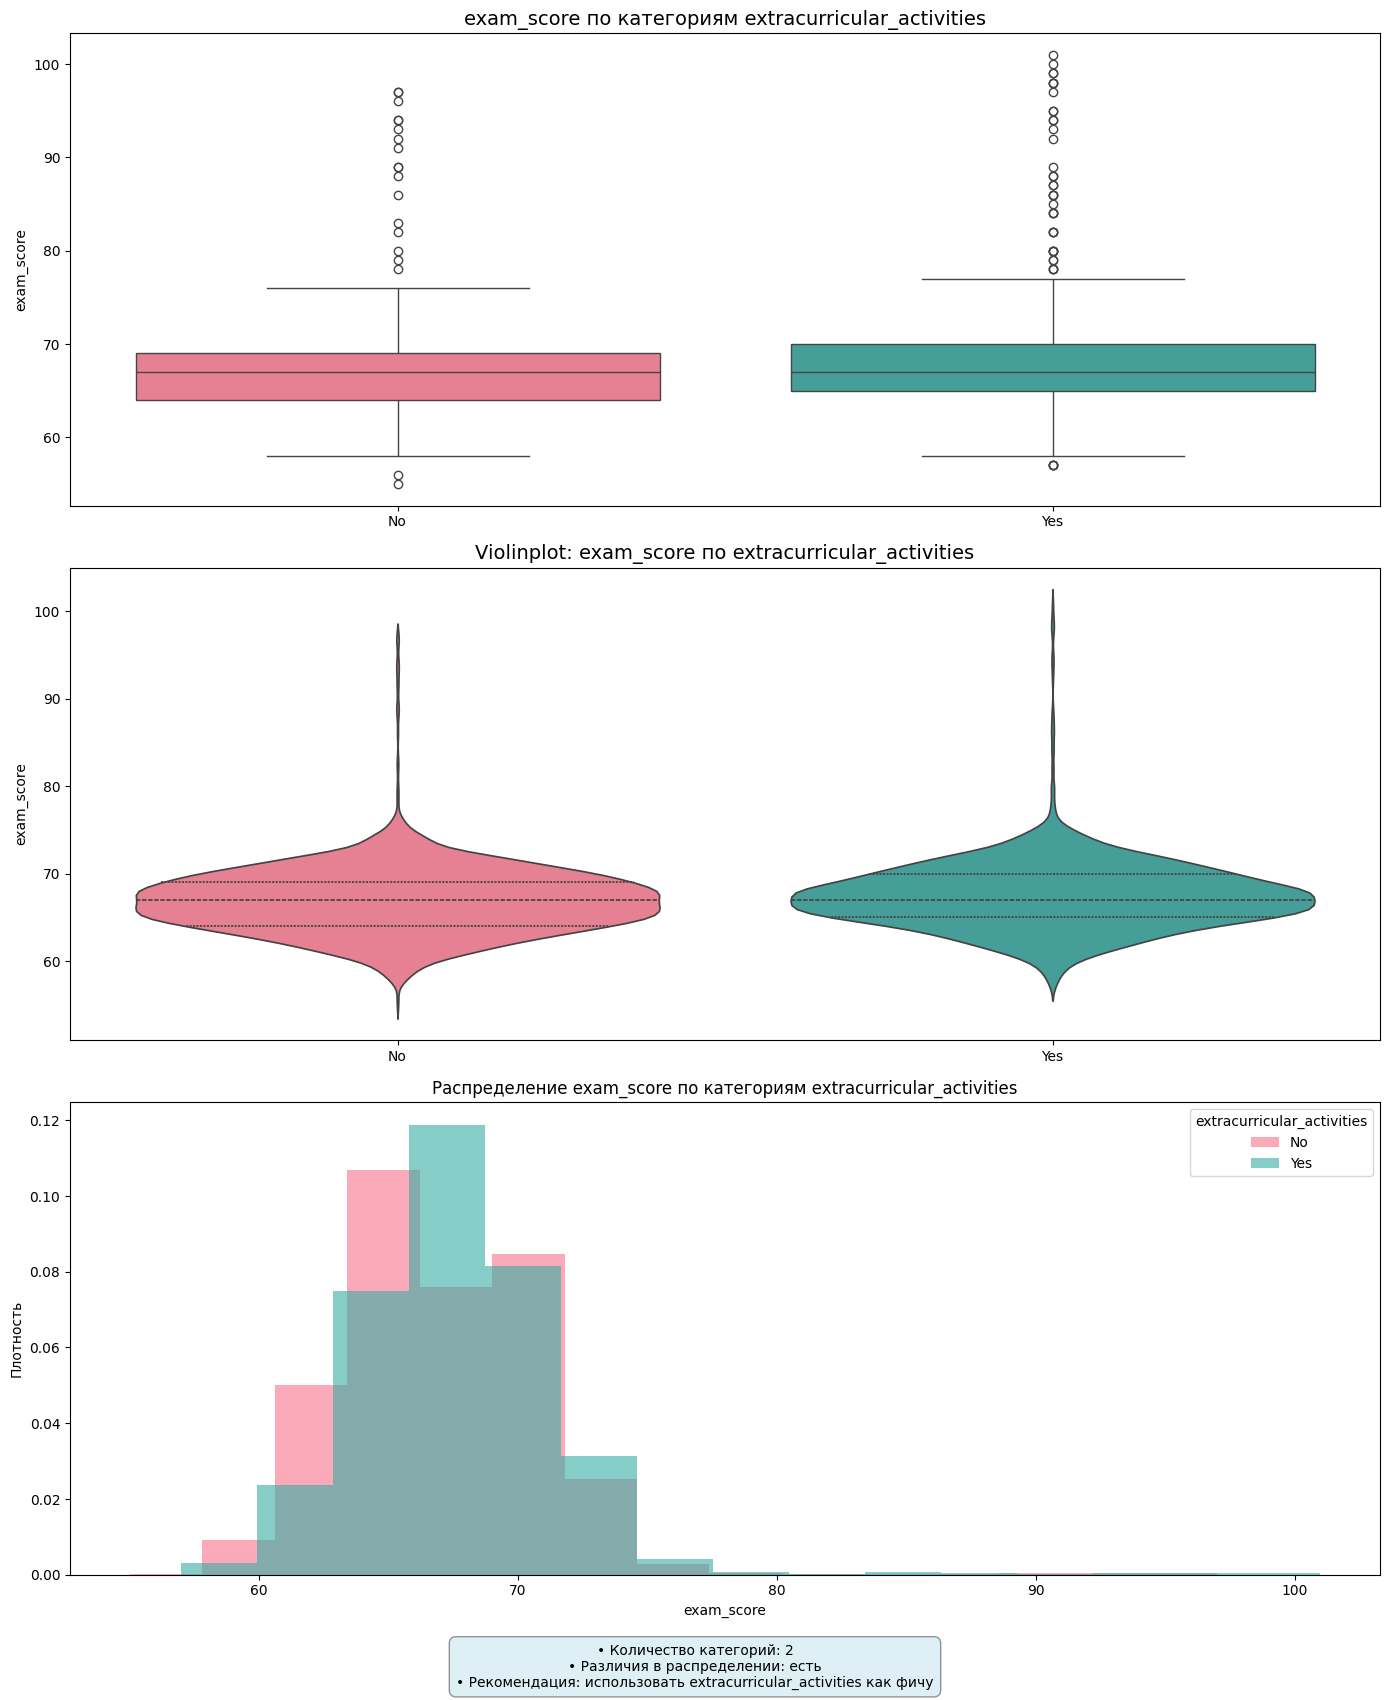

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


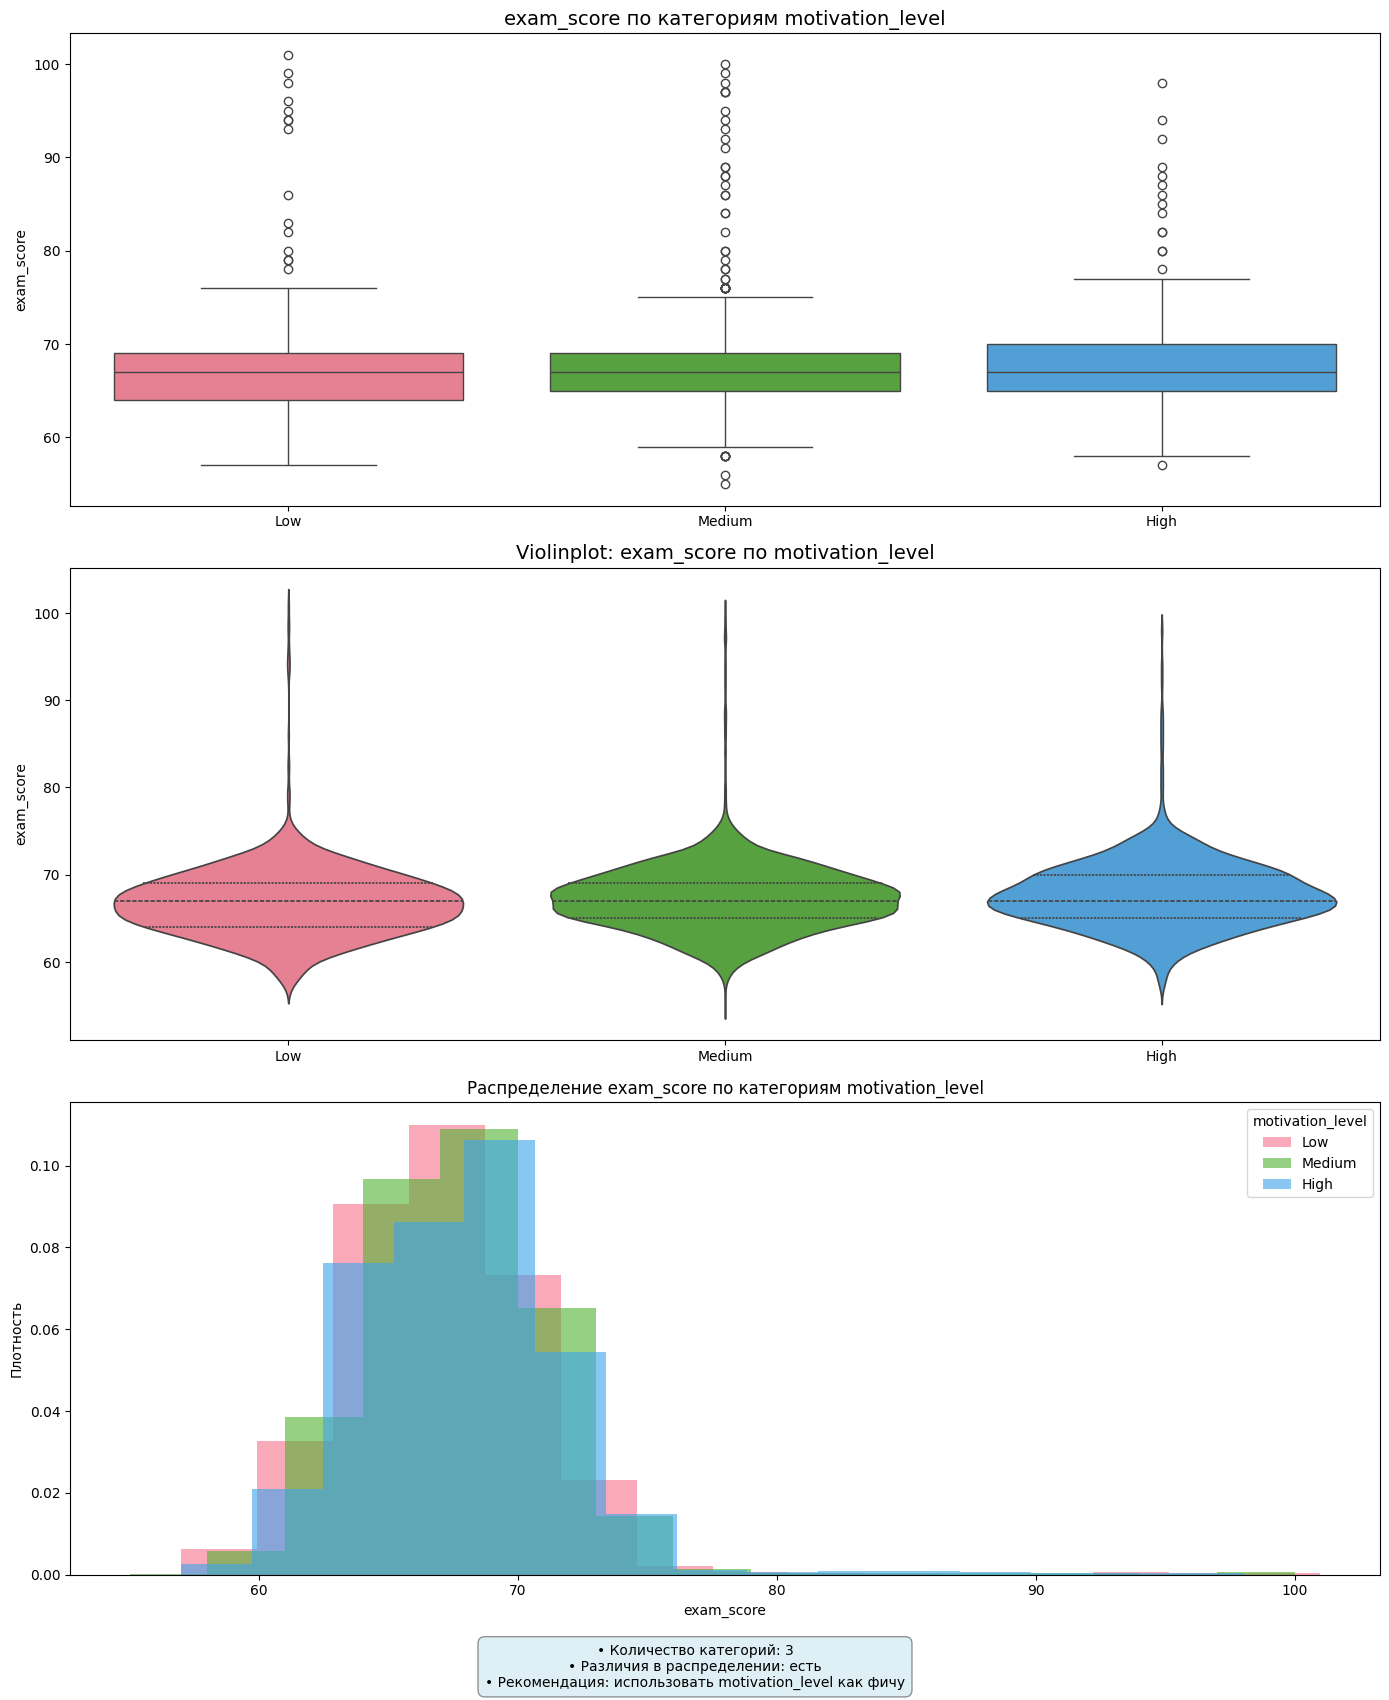

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


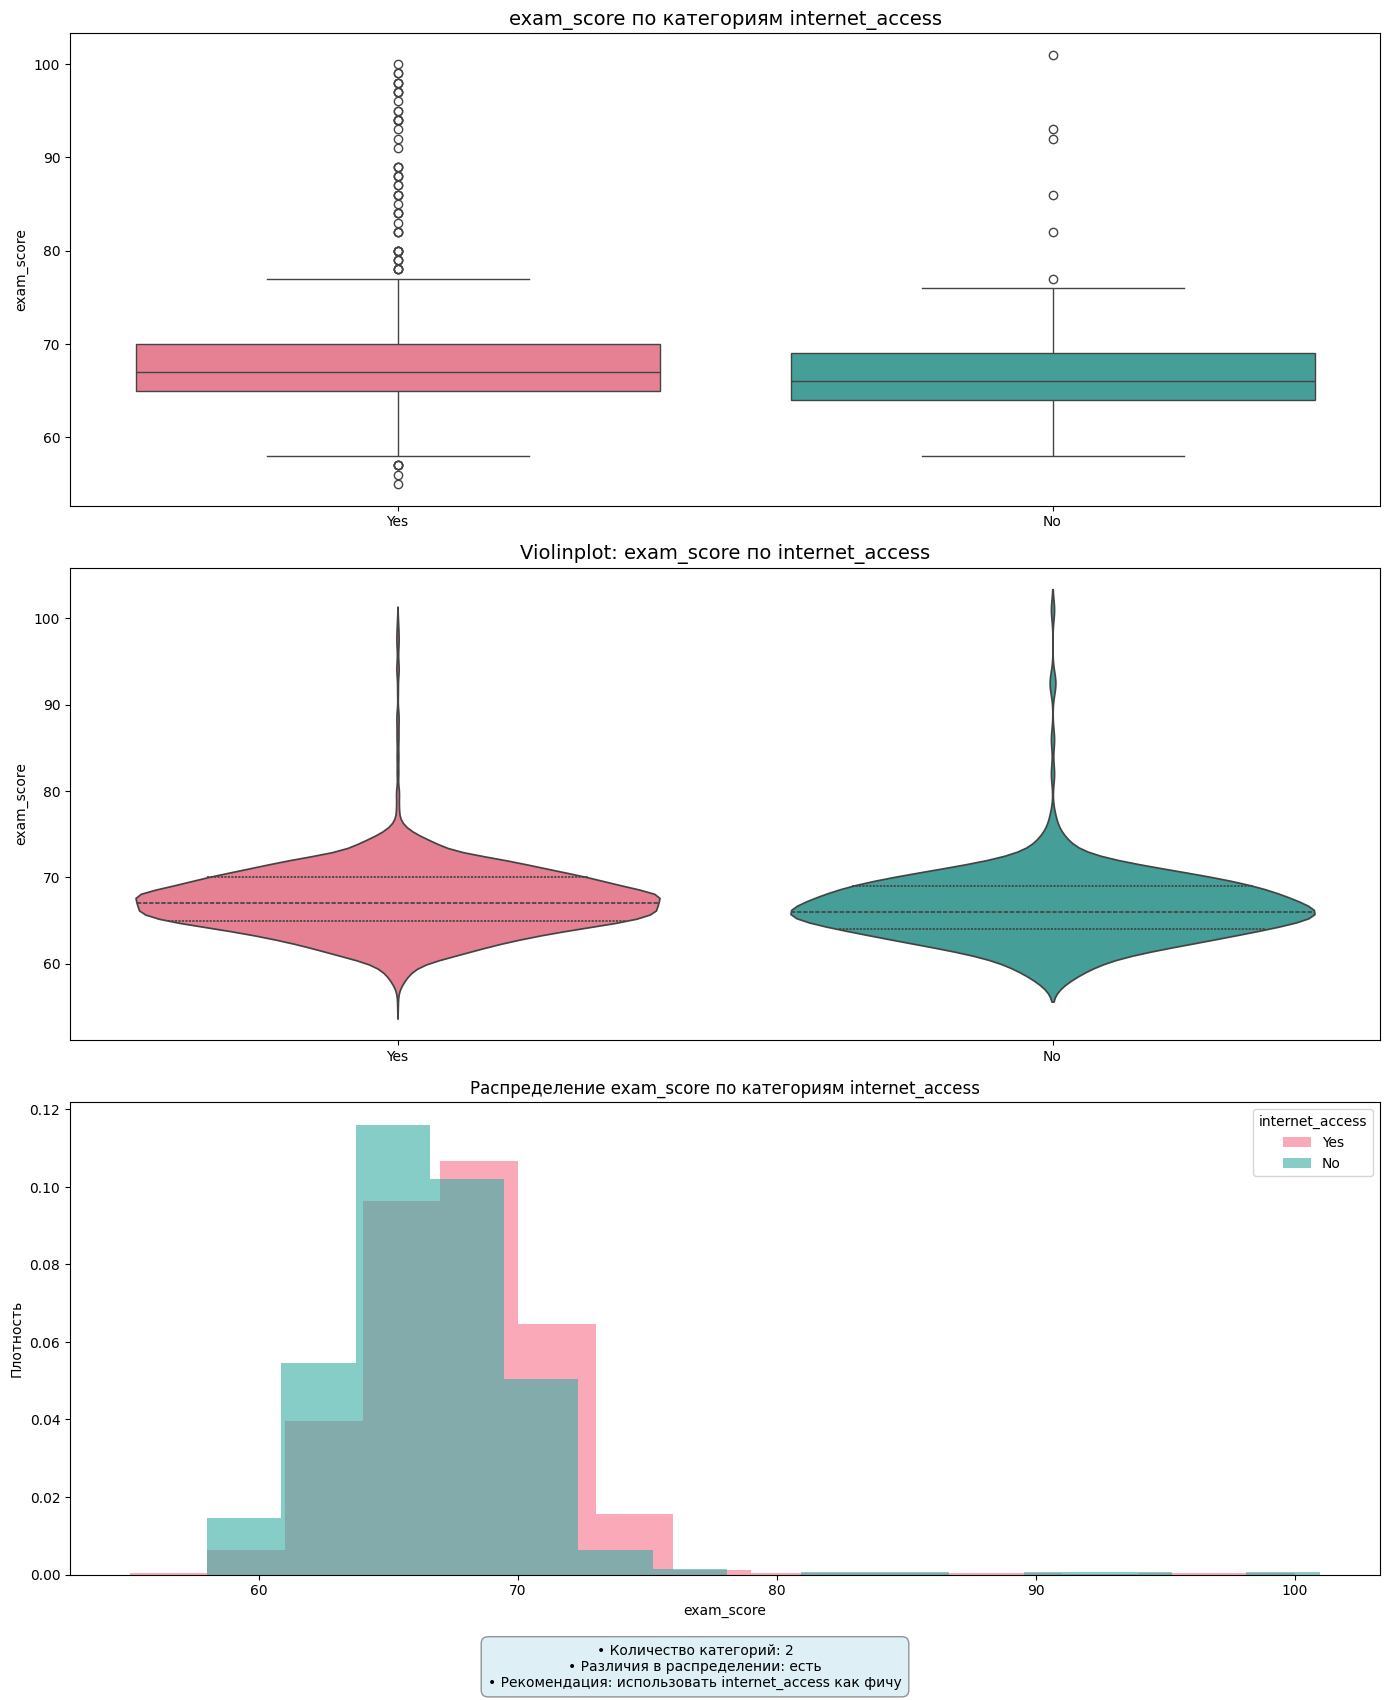

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


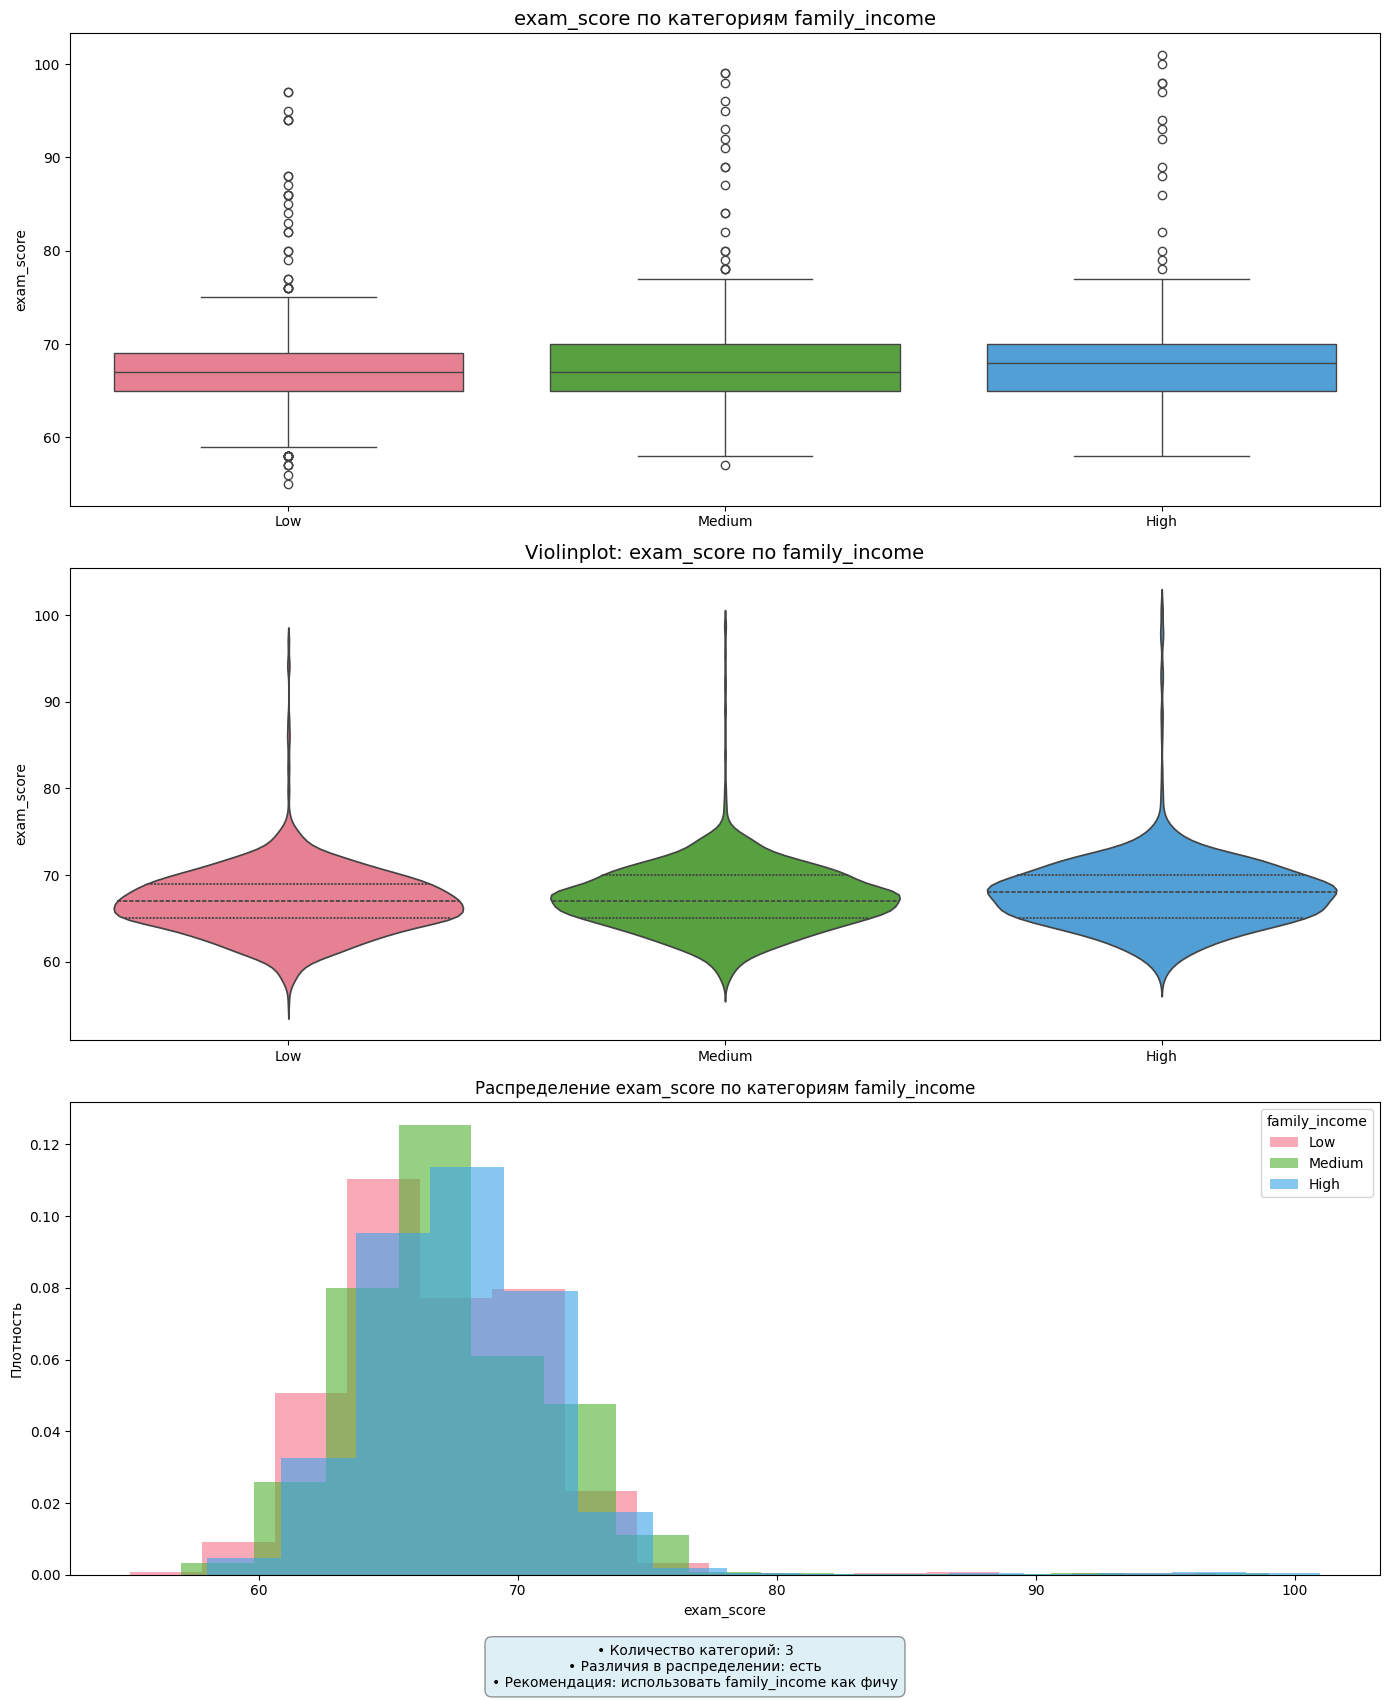

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


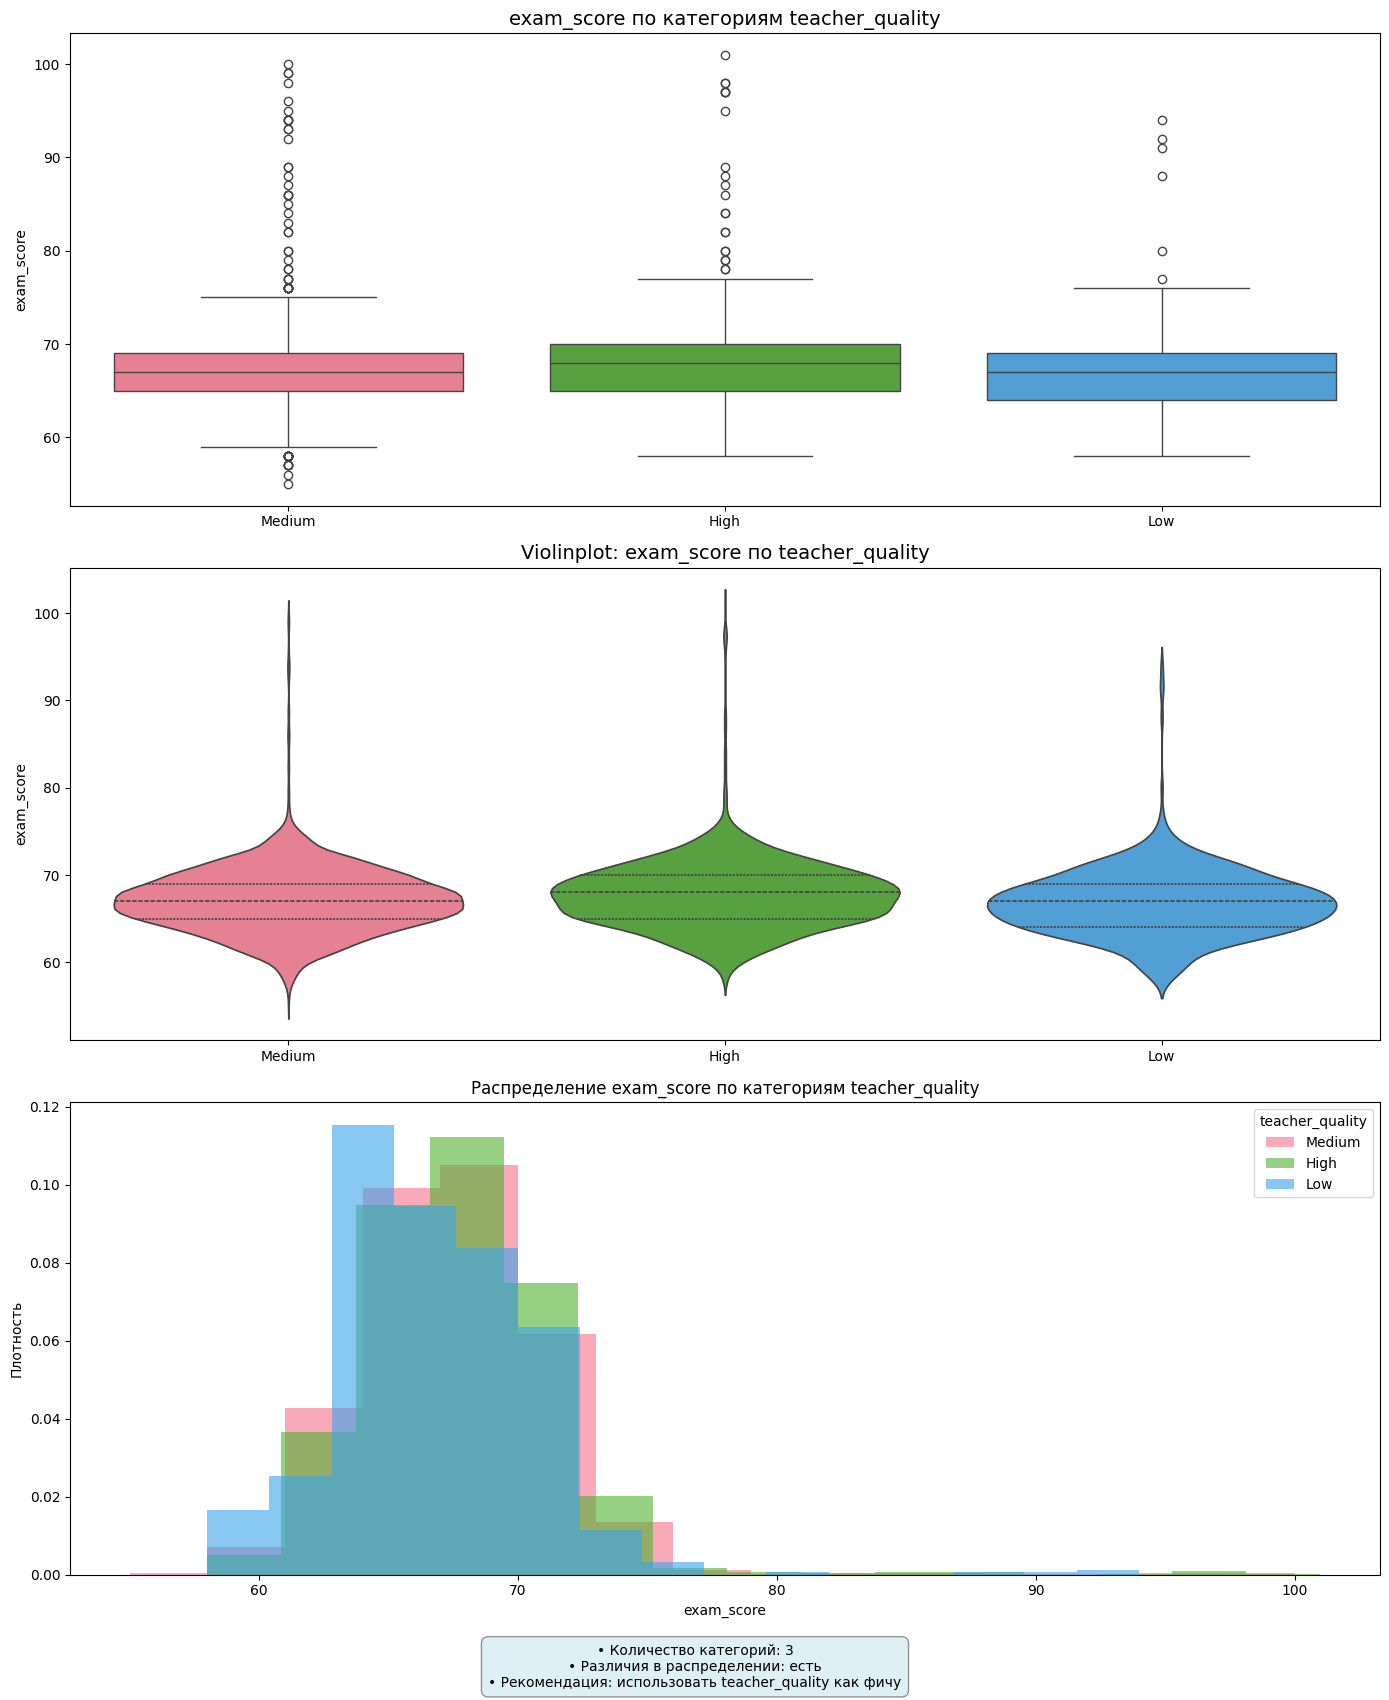

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


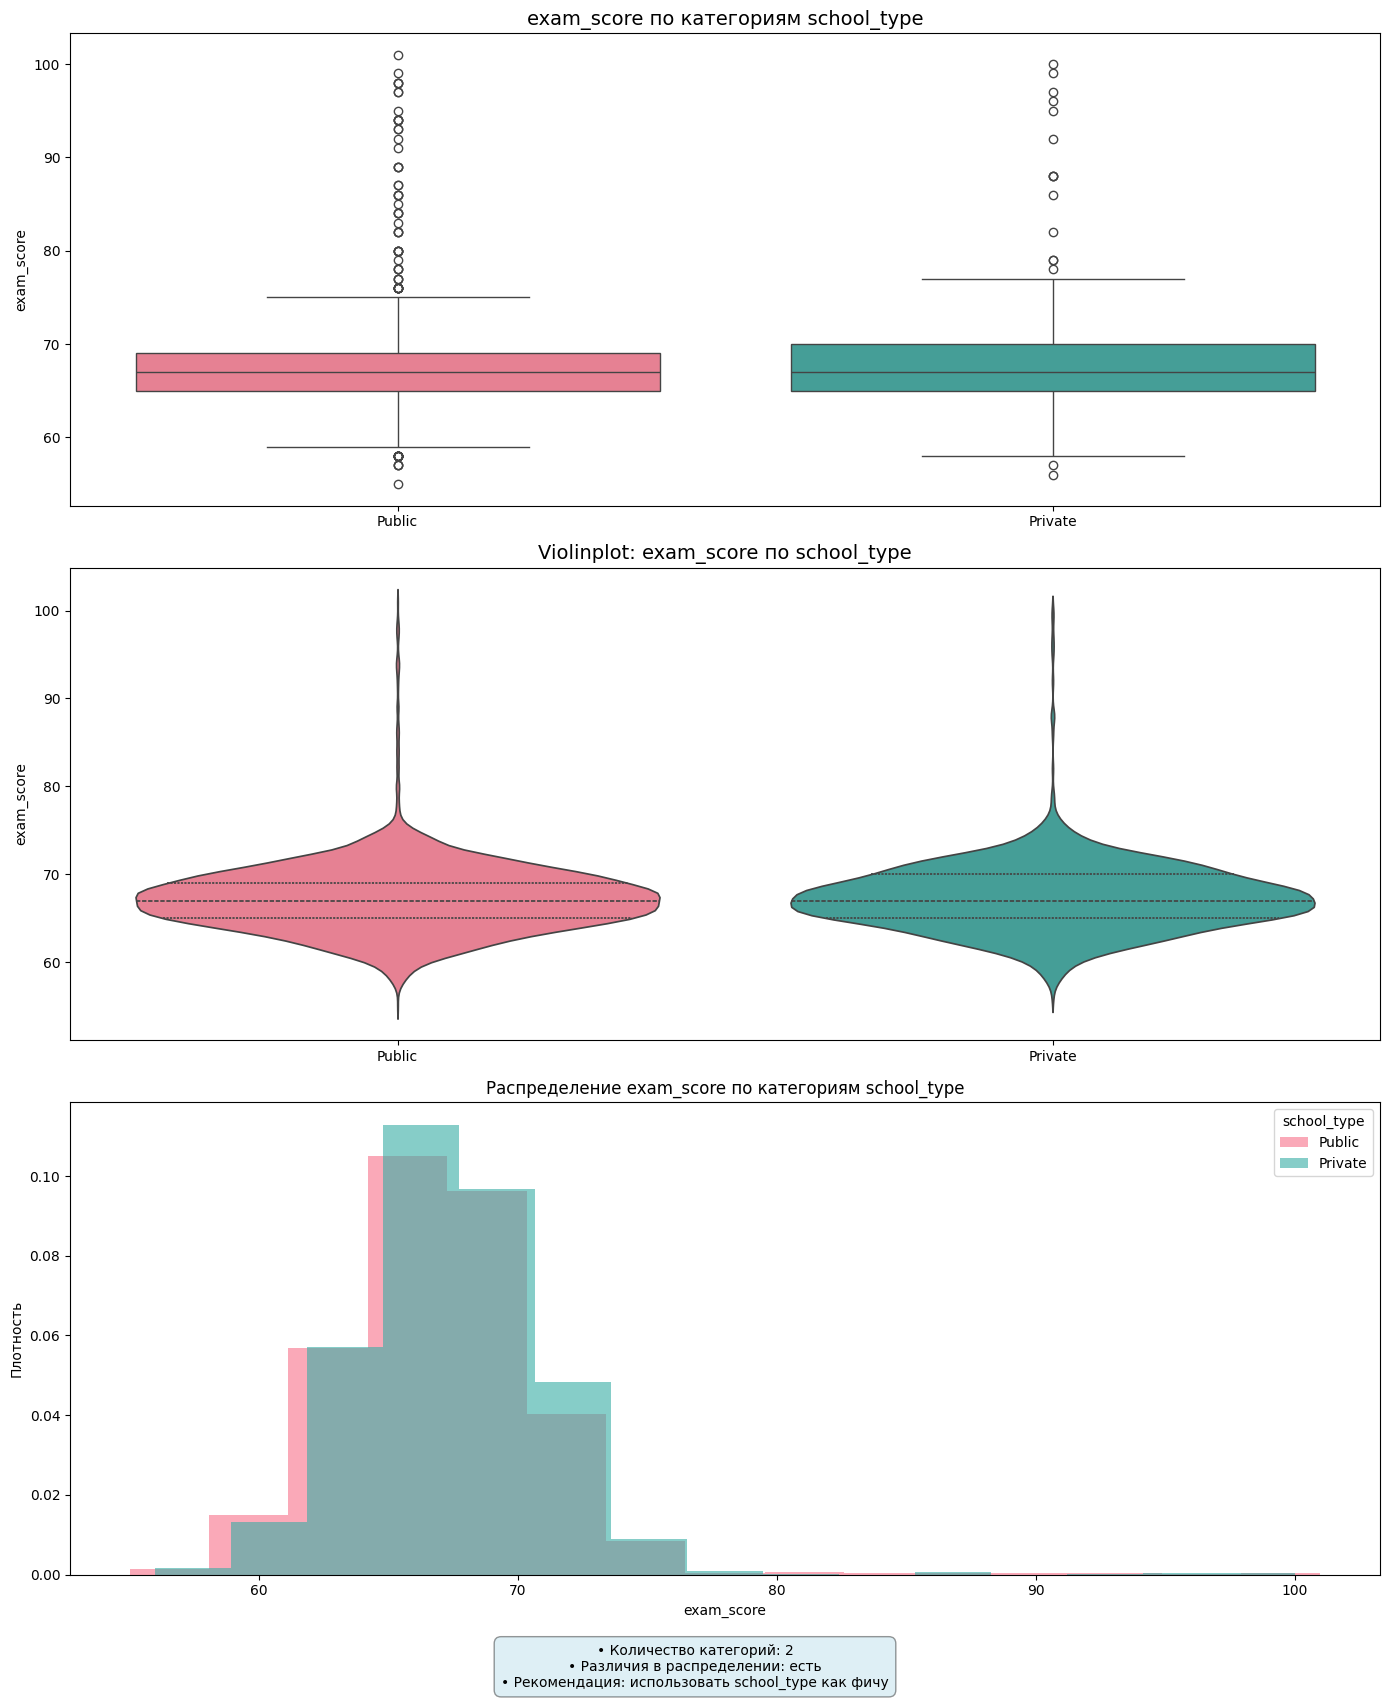

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


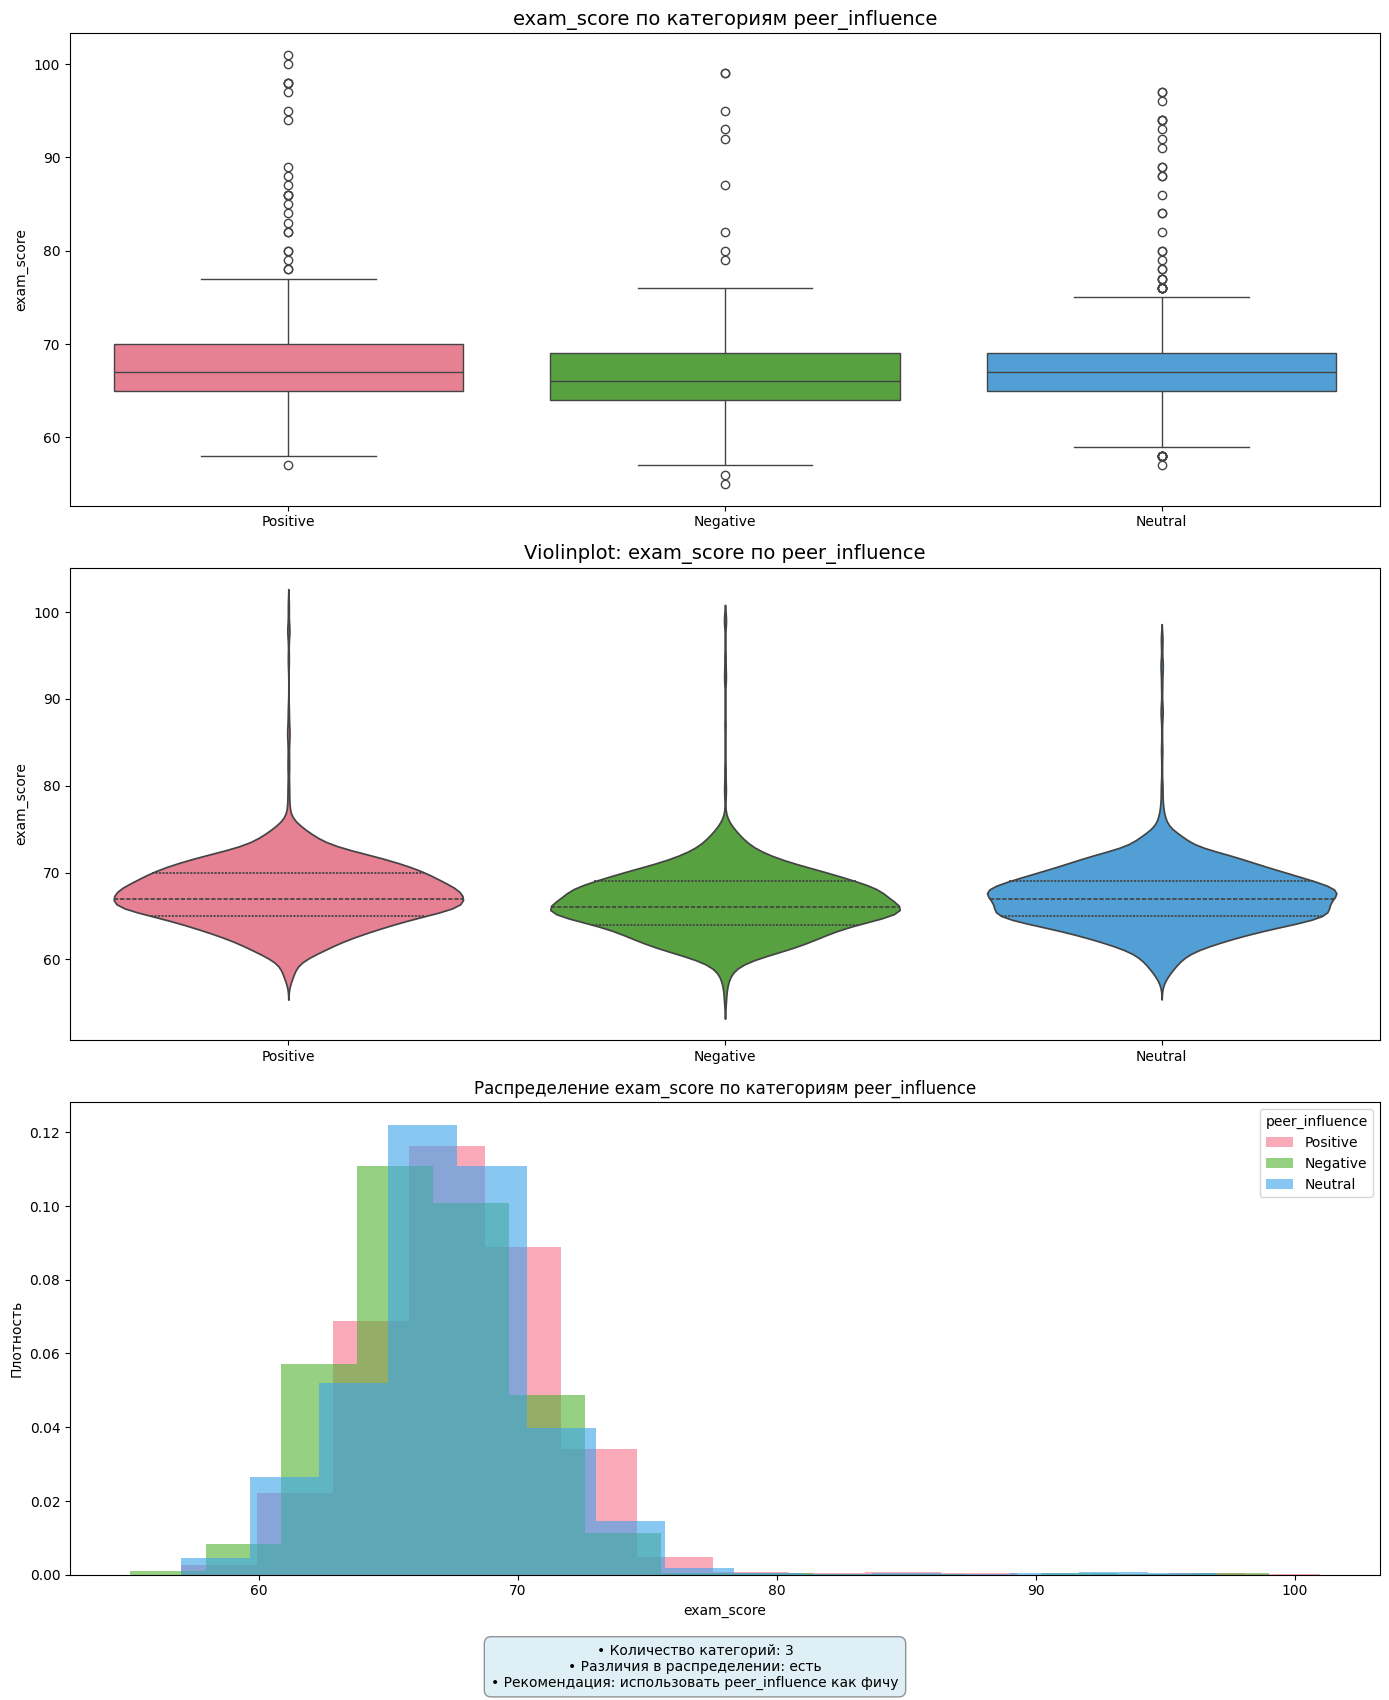

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


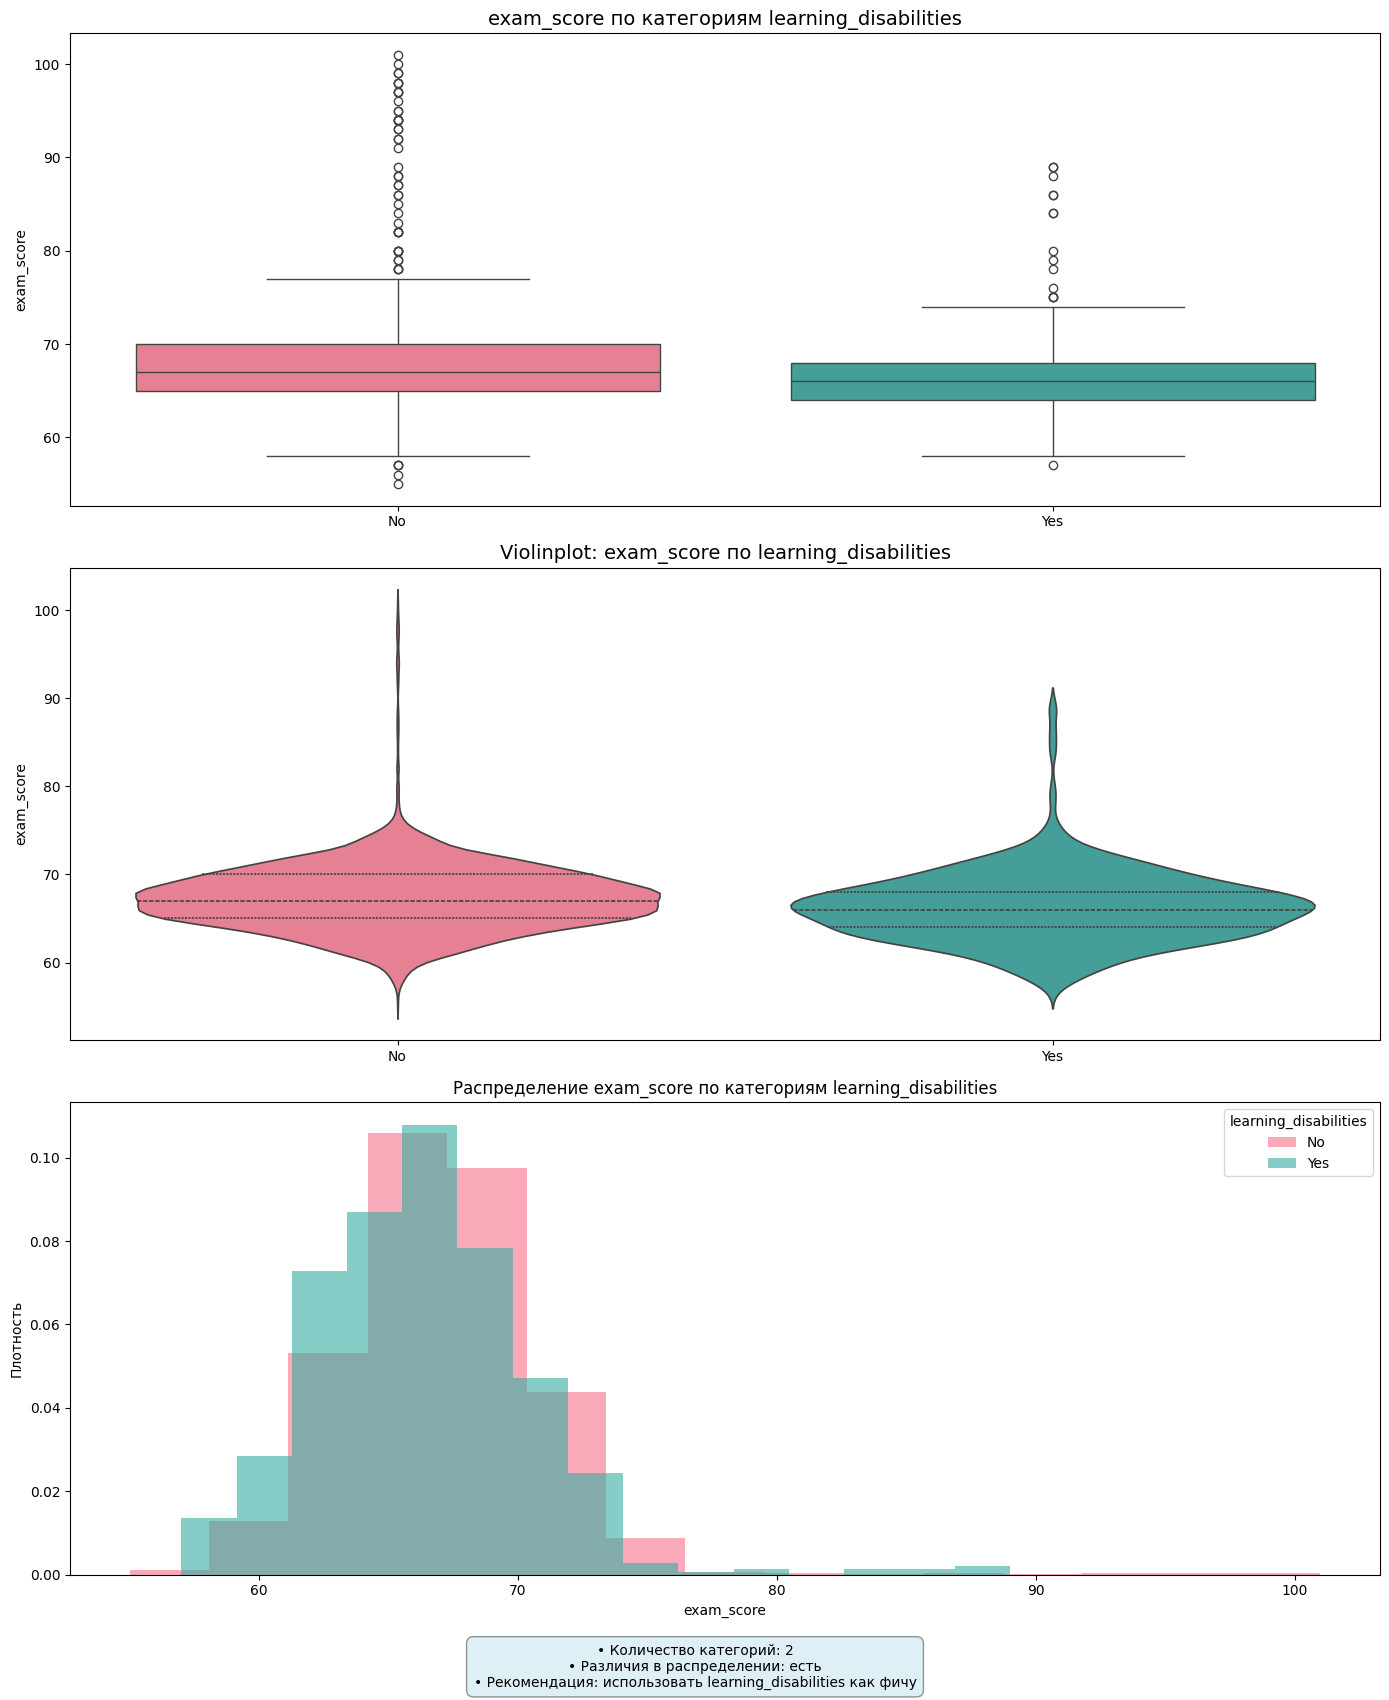

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


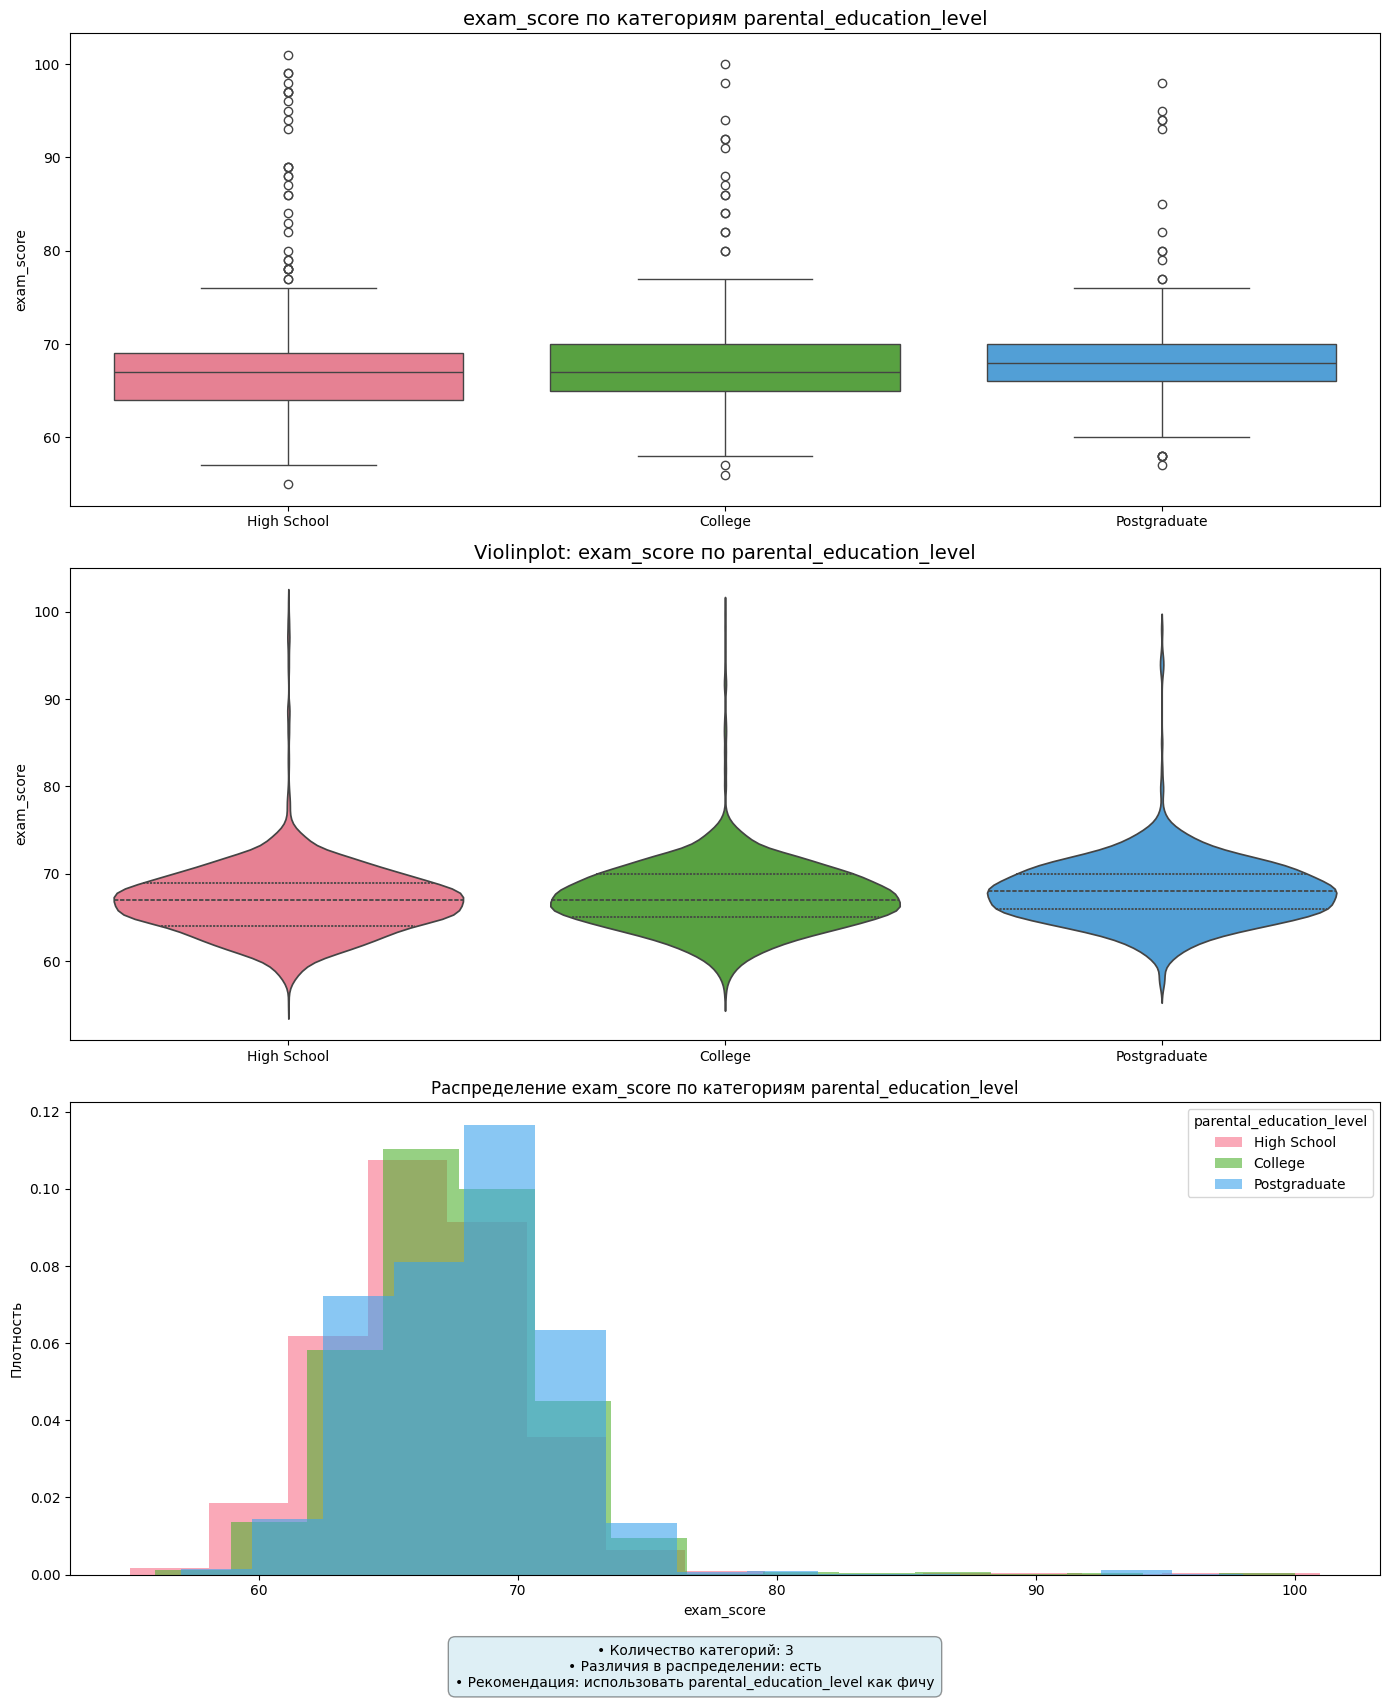

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


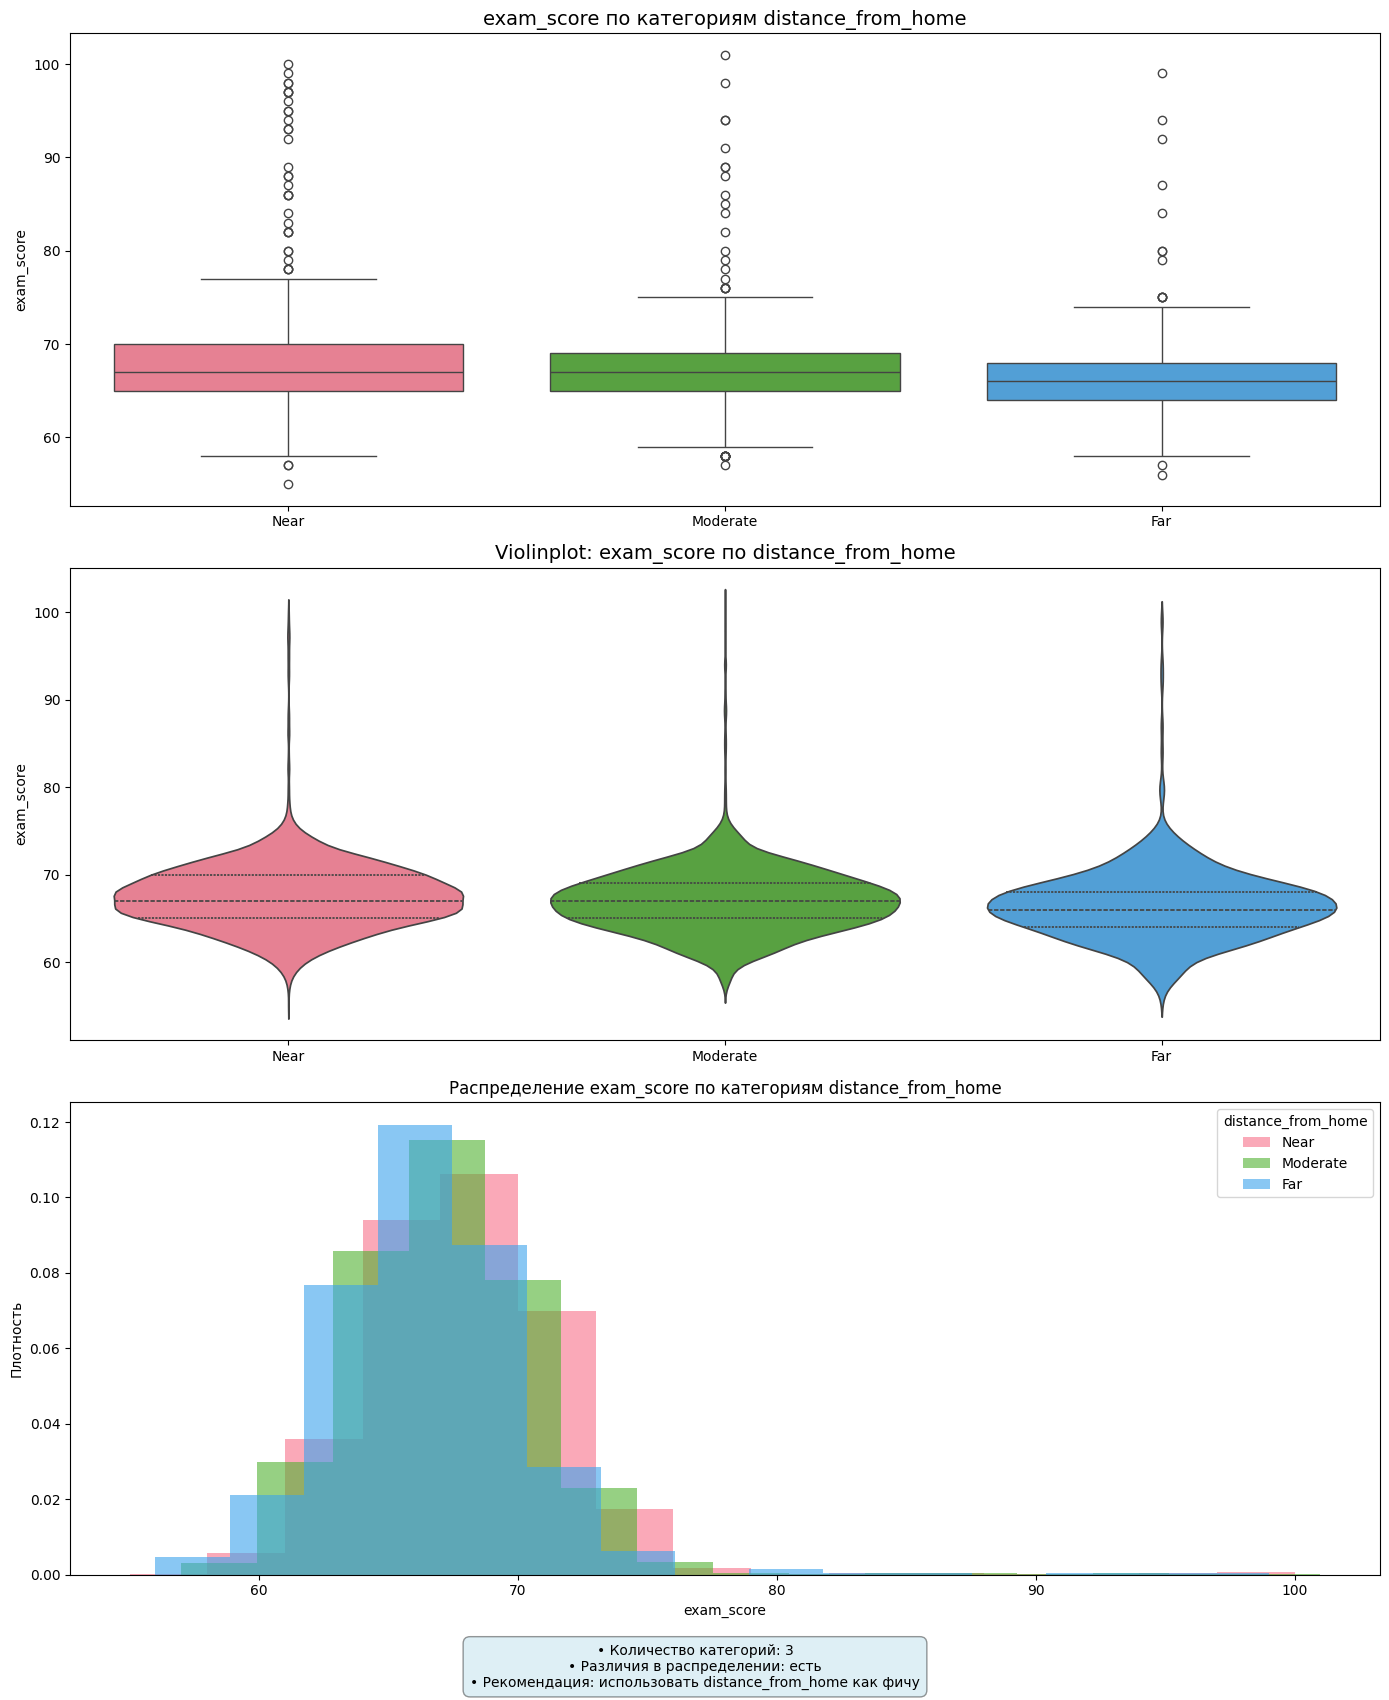

/tmp/ipython-input-4141830176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
/tmp/ipython-input-4141830176.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')


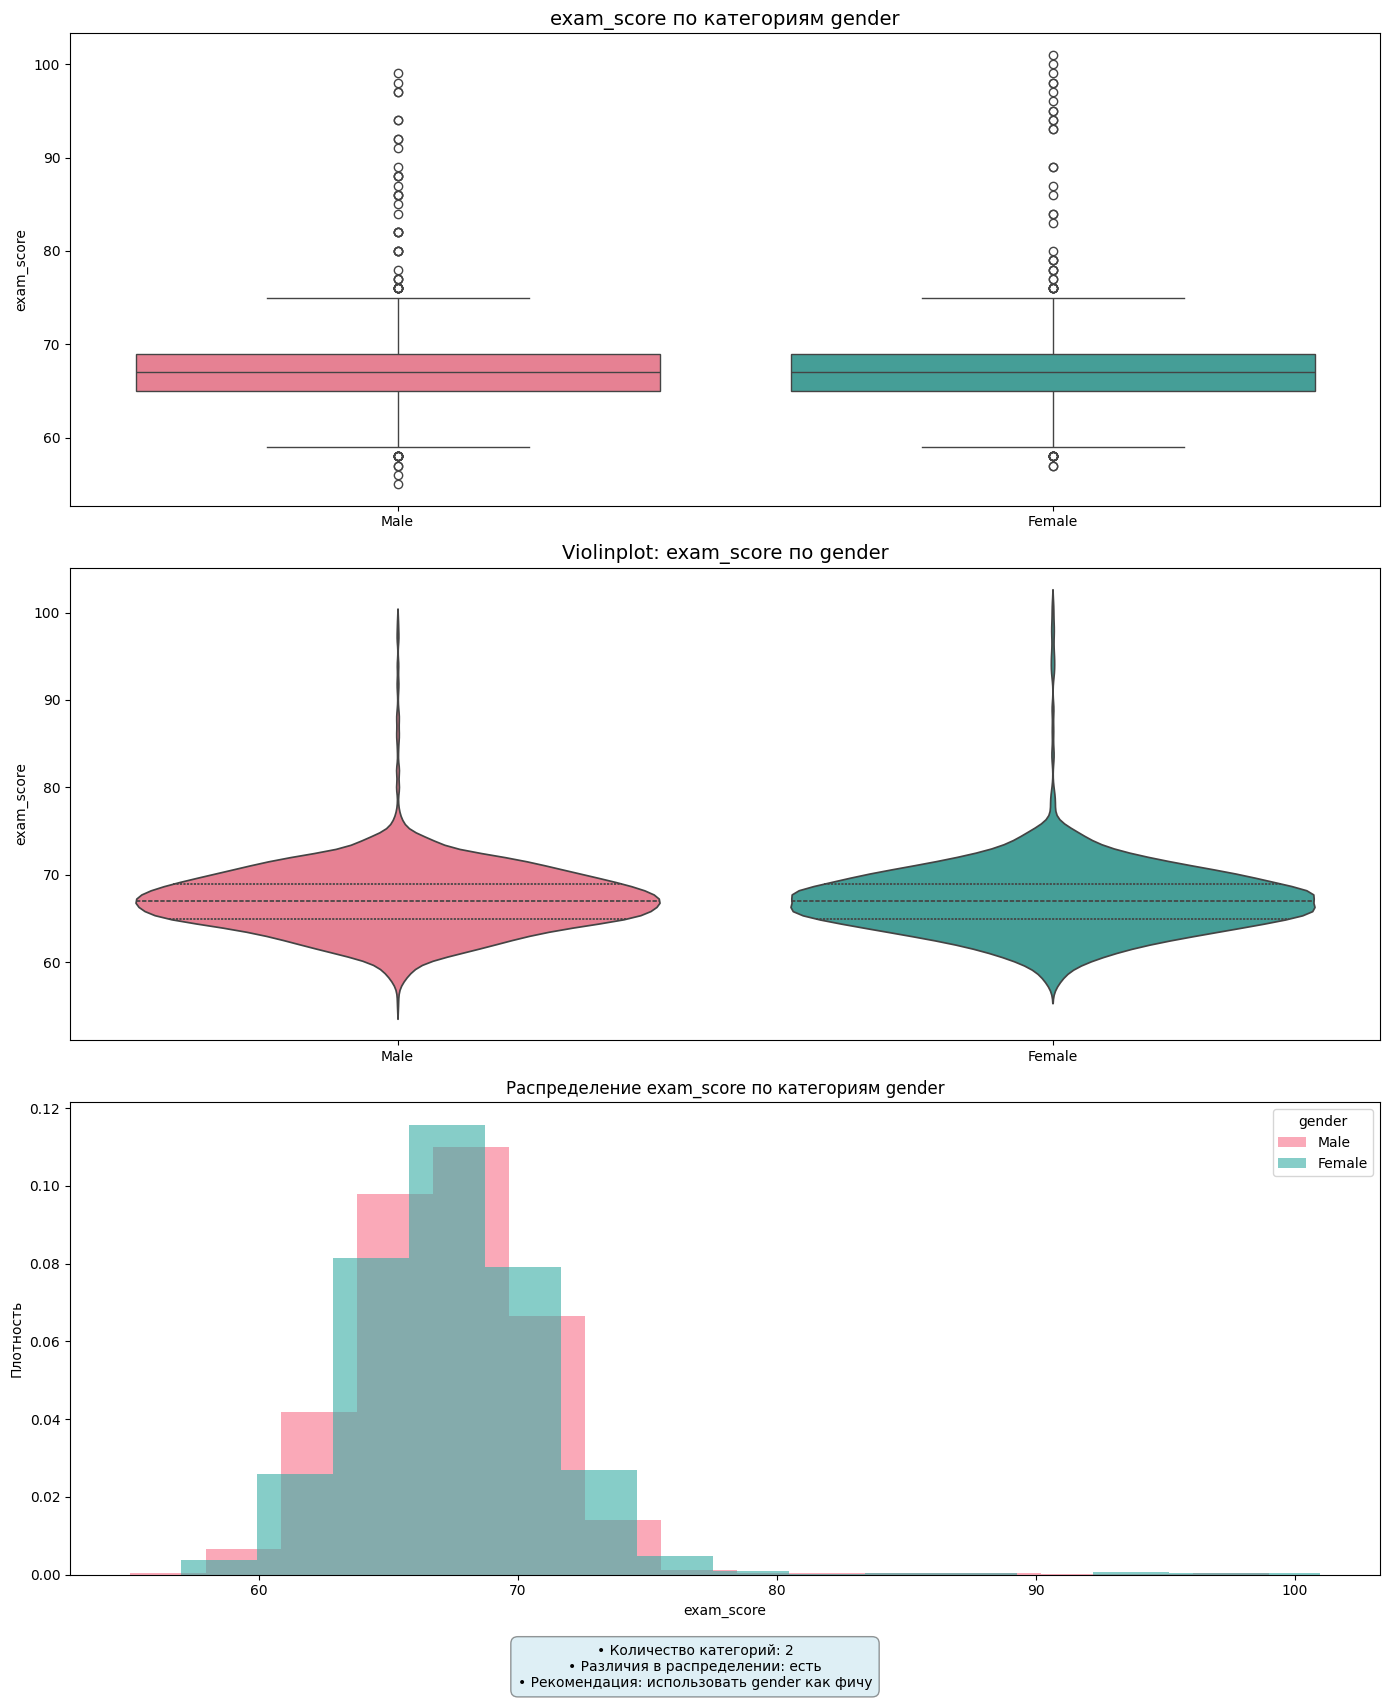

In [21]:
# Выбираем целевой количественный признак
target = 'exam_score'

# Для каждого категориального признака строим объединённый график
for cat_col in categorical_cols:
    plt.figure(figsize=(14, 18))

    # Убираем пропуски
    data = df[[target, cat_col]].dropna()

    # Проверяем количество категорий
    n_cats = data[cat_col].nunique()
    if n_cats > 10:
        print(f"❌ {cat_col} имеет {n_cats} категорий — слишком много для графика")
        continue

    # Настройка цветов
    colors = sns.color_palette("husl", n_cats)

    # 1. Верхняя часть: Boxplot
    plt.subplot(3, 1, 1)
    sns.boxplot(data=data, x=cat_col, y=target, palette=colors)
    plt.title(f'{target} по категориям {cat_col}', fontsize=14)
    plt.xlabel('')
    plt.ylabel(target)

    # 2. Средняя часть: Violinplot
    plt.subplot(3, 1, 2)
    sns.violinplot(data=data, x=cat_col, y=target, palette=colors, inner='quartile')
    plt.title(f'Violinplot: {target} по {cat_col}', fontsize=14)
    plt.xlabel('')
    plt.ylabel(target)

    # 3. Нижняя часть: Гистограммы с наложением
    plt.subplot(3, 1, 3)
    for i, category in enumerate(data[cat_col].unique()):
        subset = data[data[cat_col] == category]
        plt.hist(subset[target], bins=15, alpha=0.6,
                 color=colors[i], label=category, density=True)
    plt.xlabel(target)
    plt.ylabel('Плотность')
    plt.title(f'Распределение {target} по категориям {cat_col}')
    plt.legend(title=cat_col, loc='upper right', fontsize=10)

    # Компактный вывод под графиком
    conclusion = (
        f"• Количество категорий: {n_cats}\n"
        f"• Различия в распределении: {'есть' if n_cats > 1 else 'нет'}\n"
        f"• Рекомендация: использовать {cat_col} как фичу"
    )
    plt.figtext(0.5, 0.02, conclusion,
                ha="center", fontsize=10,
                bbox=dict(facecolor='lightblue', alpha=0.4, boxstyle="round,pad=0.5"))

    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()

Вывод:
1. Parental_Involvement: Участие родителей мало влияет на обучение ученика. Отдельно надо посмотреть на выбросы. Может те кто получают высокие баллы. У них по другому. Но медиана у высоких выше
2. Access_to_Resources: От доступа к различным ресурсам сильно вляет на баллы
3. Extracurricular_Activities: Медиана одинаковая. Получается в среднем не влияет
4. Motivation_Level: Непонятно, но тут при замене данных нужно сделать, что Low влияет сильнее на обучение. Скорее это оценка от учителей. Даже студенты с низкой увлеченностью получили высокий балл. Скорее они занимаются отдельно. Для этого признака надо применить OneHotEncoder
5. Internet_Access: Влияет на оценку
6. Family_Income: Влияет на оценку
7. Teacher_Quality: Перенести в OneHotEncoder
8. School_Type:Невлияет на оценку
9. Peer_Influence: Влияет на оценку
10. Learning_Disabilities: Влияет на оценку
11. Parental_Education_Level: Невлияет, но если смотреть на выбросы, то влияет
12. Distance_from_Home: Влияет на оценку
13. Gender: Невлияет на оценку

#### Два категориальных признака, кроме целевого
Туман анализа

In [22]:
# # Находим ВСЕ категориальные признаки
# categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# print(f"Найдено категориальных признаков: {len(categorical_cols)}")
# print("Категориальные признаки:", categorical_cols)

In [23]:
# # Проверяем, достаточно ли признаков
# if len(categorical_cols) < 2:
#     print("❌ Недостаточно категориальных признаков для анализа (нужно минимум 2)")
# else:
#     # Генерируем ВСЕ уникальные пары
#     pairs = list(itertools.combinations(categorical_cols, 2))
#     n_pairs = len(pairs)

#     # Авто-настройка размера сетки
#     n_cols = min(3, n_pairs)  # максимум 3 столбца
#     n_rows = int(np.ceil(n_pairs / n_cols))

#     # Создаем фигуру с адаптивным размером
#     plt.figure(figsize=(6 * n_cols, 4 * n_rows))
#     plt.suptitle('Двумерный анализ категориальных признаков', fontsize=16, y=0.98)

#     # Для каждой пары строим график
#     for i, (col1, col2) in enumerate(pairs, 1):
#         # Таблица сопряжённости
#         ct = pd.crosstab(df[col1], df[col2])

#         # Вычисляем выводы
#         total = ct.sum().sum()
#         max_val = ct.max().max()
#         max_pair = ct.stack().idxmax()
#         percent = (max_val / total) * 100

#         # Формируем вывод
#         if percent > 50:
#             conclusion = f"⚠️ Сильная связь: {max_pair[0]}+{max_pair[1]} ({percent:.1f}%)"
#         elif percent > 30:
#             conclusion = f"⚠️ Умеренная связь: {max_pair[0]}+{max_pair[1]} ({percent:.1f}%)"
#         else:
#             conclusion = f"✅ Слабая связь: {max_pair[0]}+{max_pair[1]} ({percent:.1f}%)"

#         # Подграфик
#         plt.subplot(n_rows, n_cols, i)
#         sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
#         plt.title(f"{col1} vs {col2}", pad=10)
#         plt.xlabel(col2)
#         plt.ylabel(col1)

#         # Добавляем вывод ПОД графиком
#         plt.text(0.5, -0.4, conclusion,
#                  horizontalalignment='center',
#                  transform=plt.gca().transAxes,
#                  fontsize=9,
#                  bbox=dict(facecolor='yellow' if 'Сильная' in conclusion else 'lightgreen',
#                            alpha=0.3,
#                            boxstyle="round,pad=0.3"))

#     plt.tight_layout(rect=[0, 0, 1, 0.96])  # место для общего заголовка
#     plt.show()

#### Отношение числовых признаков

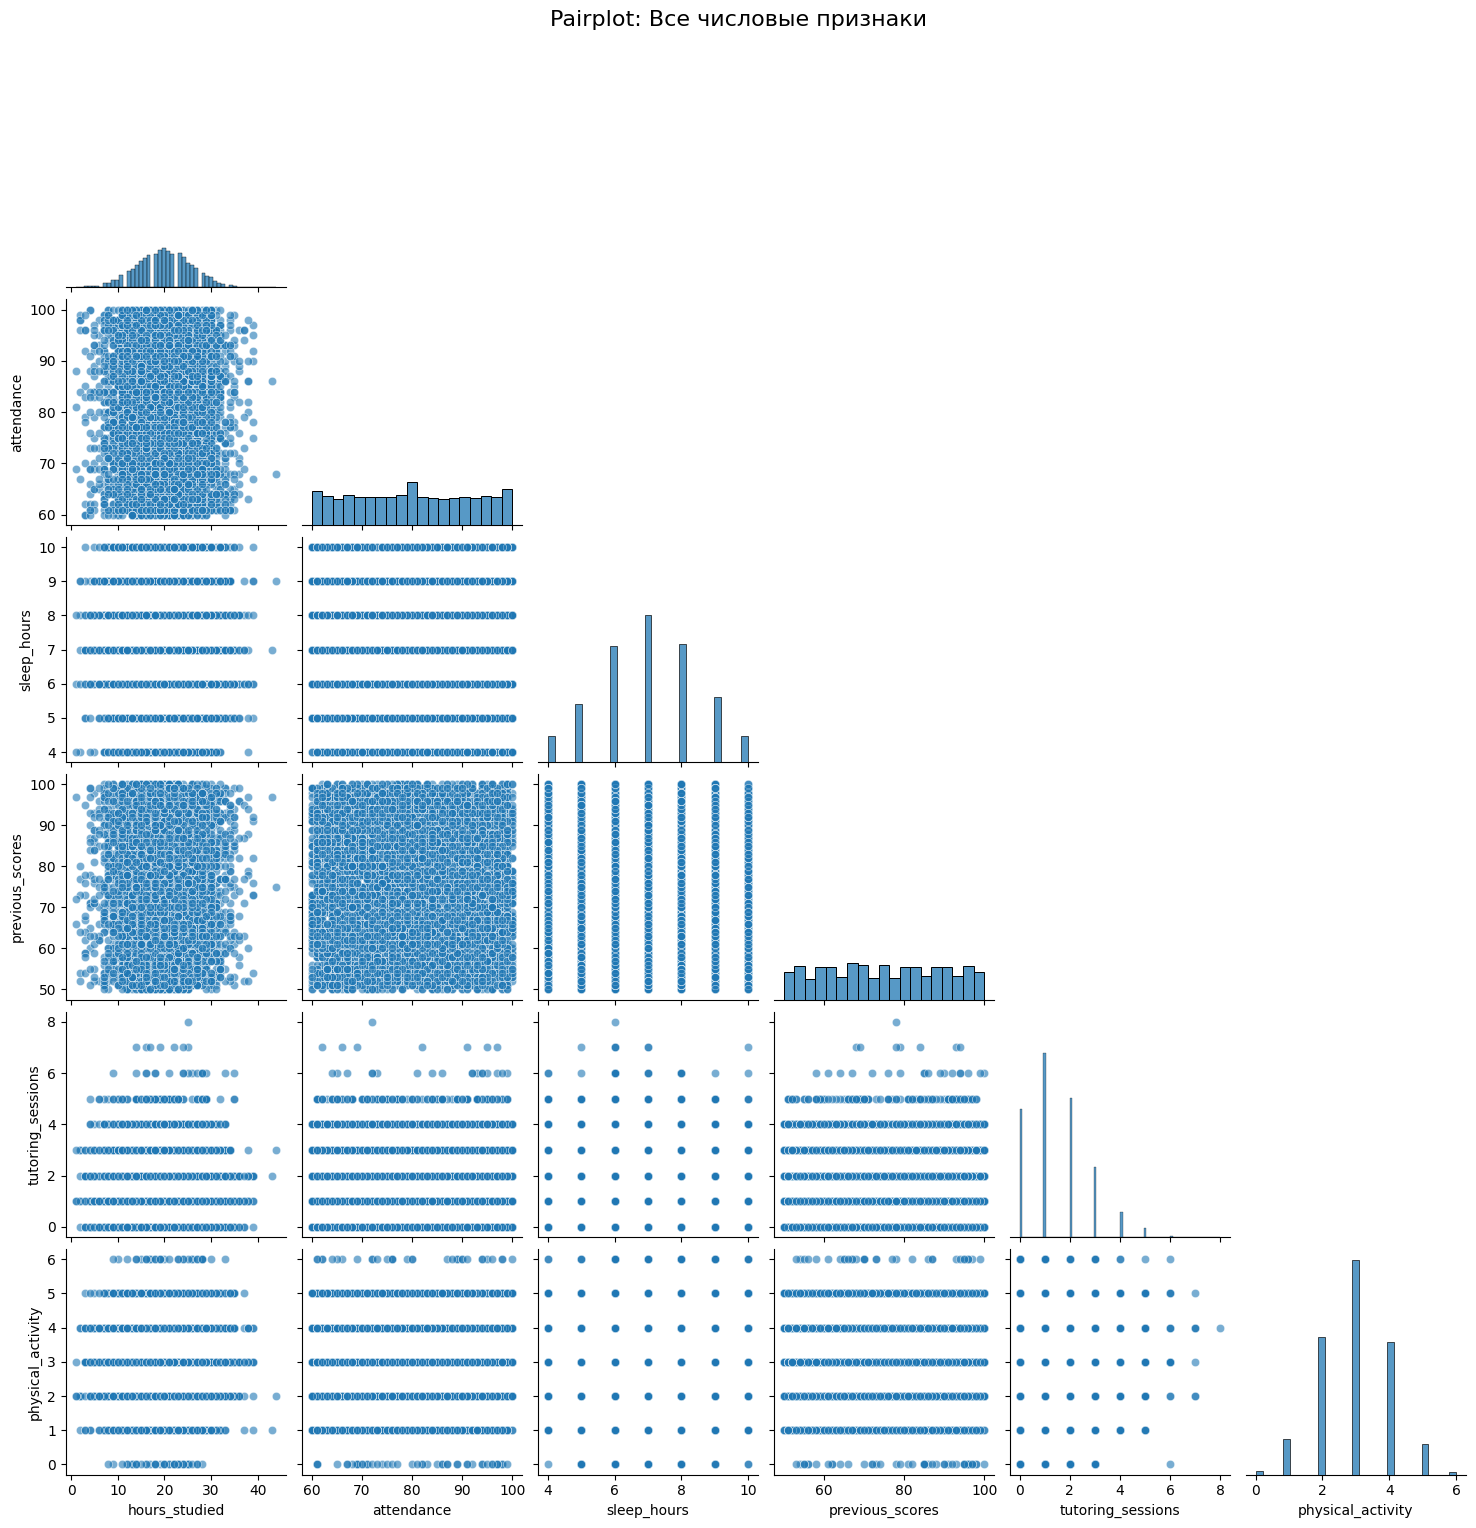

In [24]:
# Pairplot: scatter plots + гистограммы
sns.pairplot(df[[col for col in numeric_cols if col != target]], diag_kind='hist', plot_kws={'alpha': 0.6}, corner=True)
# sns.pairplot(df[numeric_cols], diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot: Все числовые признаки', y=1.02, fontsize=16)
plt.show()

Вывод: Студенты, которые чаще посещают занятия и учатся больше, обычно получают более высокие оценки. Однако есть конфликт между временем учёбы и сном — чем больше учишься, тем меньше спишь. Предыдущие оценки показывают сильную асимметрию, что может влиять на модели. Репетиторские сессии редко используются, поэтому этот признак может быть избыточным.

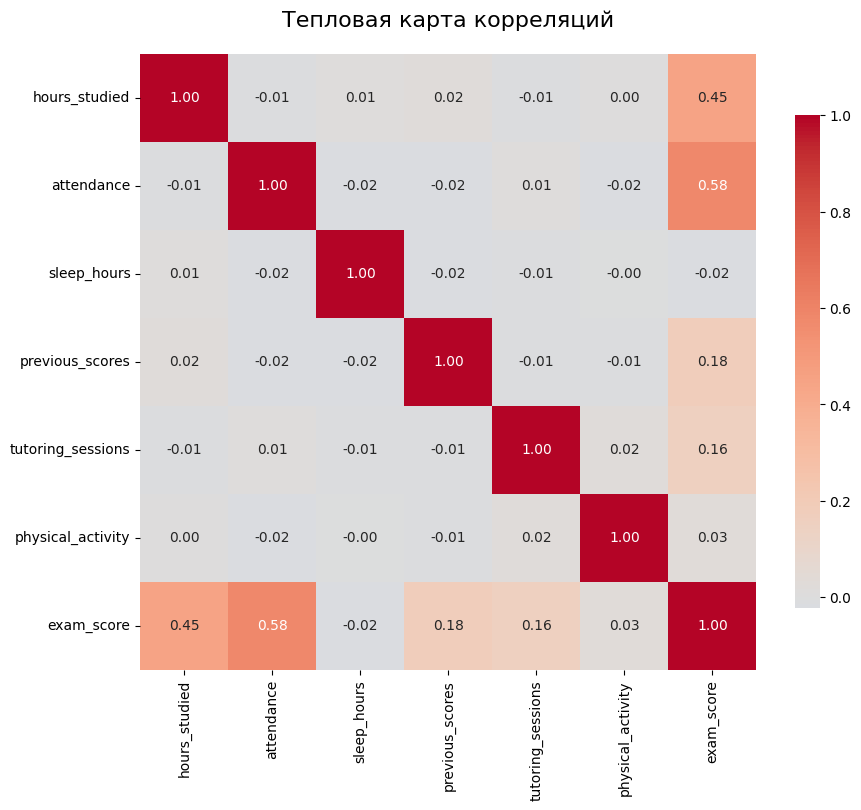

In [25]:
df_numeric = df[numeric_cols]

# Матрица корреляций
corr_matrix = df_numeric.corr()

# Тепловая карта
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # числа в ячейках
    fmt=".2f",            # 2 знака после запятой
    cmap='coolwarm',      # цвет: красный — +1, синий — -1
    center=0,             # центр на 0
    square=True,          # квадратные ячейки
    cbar_kws={"shrink": 0.8}
)
plt.title('Тепловая карта корреляций', fontsize=16, pad=20)
plt.show()

## Шаг 7: Мультиколлинеарность и избыточность

In [26]:
# Найдём пары с высокой корреляцией
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append((col1, col2, round(corr_val, 2)))

print("\n📌 Сильные корреляции (|r| > 0.7):")
if high_corr:
    for c1, c2, r in high_corr:
        print(f"  • {c1} ↔ {c2}: {r}")
else:
    print("  • Не найдено")


📌 Сильные корреляции (|r| > 0.7):
  • Не найдено


Вывод: признаков с высокой корреляцией нет

# Предобработка данных

## Шаг 1. Обработка пропущенных данных

1. teacher_quality: пока не понимаю, что делать с данными пропусками, возможзно создать 4 пункт. Unknown
2. parental_education_level: 4 пункт Unknown
3. distance_from_home: 4 пункт Unknown

In [27]:
# Список столбцов, где нужно заменить NaN на "Unknown"
cols_to_fill = [
    'teacher_quality',
    'parental_education_level',
    'distance_from_home'
]

# Замена пропусков на "Unknown"
for col in cols_to_fill:
    if col in df.columns and df[col].dtype == 'object':
        print(f"Заменяем NaN в '{col}' на 'Unknown'")
        df[col] = df[col].fillna('Unknown')
    else:
        print(f"❌ Столбец '{col}' не найден или не строковый")

Заменяем NaN в 'teacher_quality' на 'Unknown'
Заменяем NaN в 'parental_education_level' на 'Unknown'
Заменяем NaN в 'distance_from_home' на 'Unknown'


In [28]:
# Проверка результата
print("\nПосле замены:")
for col in cols_to_fill:
    if col in df.columns:
        print(f"{col}: {df[col].value_counts().to_dict()}")


После замены:
teacher_quality: {'Medium': 3925, 'High': 1947, 'Low': 657, 'Unknown': 78}
parental_education_level: {'High School': 3223, 'College': 1989, 'Postgraduate': 1305, 'Unknown': 90}
distance_from_home: {'Near': 3884, 'Moderate': 1998, 'Far': 658, 'Unknown': 67}


## Шаг 2. Обработка числовых признаков

Есть выбросы и их надо изучать отдельно

In [29]:
# Сохраним исходное количество строк
print(f"📌 Исходное количество строк: {len(df)}")

# Создаём копию датафрейма
df_cleaned = df.copy()

# Для каждого числового признака удаляем выбросы
for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтруем строки, где значение НЕ является выбросом
    mask = (df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)
    df_cleaned = df_cleaned[mask]

print(f"📌 Количество строк после удаления выбросов: {len(df_cleaned)}")
print(f"📉 Удалено строк: {len(df) - len(df_cleaned)} ({((len(df) - len(df_cleaned)) / len(df)) * 100:.1f}%)")

data = df_cleaned.copy()

📌 Исходное количество строк: 6607
📌 Количество строк после удаления выбросов: 6054
📉 Удалено строк: 553 (8.4%)


# Разделение данных

In [30]:
target = 'exam_score'

X = data.drop(columns=[target])  # признаки (всё кроме целевой)
y = data[target]                 # целевая переменная

# 2. Разделение: 80% — train, 20% — test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% на тест
    random_state=42,         # для воспроизводимости
    shuffle=True             # перемешиваем данные
)

# 3. Проверка размеров
print("✅ Данные успешно разделены:")
print(f"  Общее количество строк: {len(data)}")
print(f"  X_train: {X_train.shape} ({len(X_train)} строк)")
print(f"  X_test:  {X_test.shape}  ({len(X_test)} строк)")
print(f"  y_train: {y_train.shape}")
print(f"  y_test:  {y_test.shape}")

# 4. Проверка распределения целевой переменной
print(f"\n🎯 Среднее значение {target}:")
print(f"  В train: {y_train.mean():.2f}")
print(f"  В test:  {y_test.mean():.2f}")

✅ Данные успешно разделены:
  Общее количество строк: 6054
  X_train: (4843, 19) (4843 строк)
  X_test:  (1211, 19)  (1211 строк)
  y_train: (4843,)
  y_test:  (1211,)

🎯 Среднее значение exam_score:
  В train: 66.97
  В test:  67.03


# Создание Pipeline

In [31]:
# Определим признаки по типам
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


# Список трансформеров
transformers = []

# Порядки для OrdinalEncoder (важно задать порядок!)
parental_order = ['Low', 'Medium', 'High']
access_order = ['Low', 'Medium', 'High']
family_order = ['Low', 'Medium', 'High']
activities_order = ['No', 'Yes']
internet_order = ['No', 'Yes']
learning_order = ['No', 'Yes']
influence_order = ['Negative', 'Neutral', 'Positive']
education_order = ['Unknown', 'College', 'High School', 'Postgraduate']
distance_order = ['Unknown', 'Far', 'Moderate', 'Near']

# Разделяем признаки по типу кодирования
ordinal_features = [
    'parental_involvement',      # Low, Medium, High
    'access_to_resources',       # Low, Medium, High
    'family_income',             # Low, Medium, High
    'extracurricular_activities', # No, Yes
    'internet_access',           # No, Yes
    'learning_disabilities',     # No, Yes
    'peer_influence',            # Negative, Neutral, Positive
    'parental_education_level',  # Unknown, College, High School, Postgraduate
    'distance_from_home'        # Unknown, Far, Moderate, Near
]

# 1. OrdinalEncoder для порядковых признаков
if ordinal_features:
    ordinal_categories = [
        parental_order,
        access_order,
        family_order,
        activities_order,
        internet_order,
        learning_order,
        influence_order,
        education_order,
        distance_order
    ]

    ordinal_encoder = OrdinalEncoder(
        categories=ordinal_categories,
        dtype=int
    )

    transformers.append(('ordinal', ordinal_encoder, ordinal_features))

nominal_features = [
    'school_type',
    'gender',
    'motivation_level',
    'teacher_quality'
]

# 2. OneHotEncoder для номинальных
if nominal_features:
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    transformers.append(('nominal', onehot_encoder, nominal_features))

# 3. StandardScaler для числовых (опционально)
if numeric_features:
    scaler = StandardScaler()
    transformers.append(('numeric', scaler, numeric_features))

# Создаём ColumnTransformer
preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Регрессия

In [92]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [93]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Negative',
                                                                              'Neutral',
                                                                              'Positive'],
                                                                             ['Unknown',
                                                                              'College',
                                                                              'High '
                                                                              'School',
                                                                              'Postgraduate'],
                                                                             ['Unknown',
                                                                              'Far',
                                                                              'Moderate'...
                                                   'peer_influence',
                                                   'parental_education_level',
                                                   'distance_from_home']),
                                                 ('nominal',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type', 'gender',
                                                   'motivation_level',
                                                   'teacher_quality']),
                                                 ('numeric', StandardScaler(),
                                                  ['hours_studied',
                                                   'attendance', 'sleep_hours',
                                                   'previous_scores',
                                                   'tutoring_sessions',
                                                   'physical_activity'])])),
                ('model', LinearRegression())])

In [94]:
# Предсказание
y_pred = pipeline_lr.predict(X_test)

# Оценка модели
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

R²: 0.974
MAE: 0.413


In [100]:
# Функция для Optuna
def objective_reg(trial):
    # Выбор модели
    model_name = trial.suggest_categorical('model', ['linear', 'ridge', 'lasso', 'elasticnet'])

    # Построение модели с гиперпараметрами
    if model_name == 'linear':
        model = LinearRegression()
    elif model_name == 'ridge':
        alpha = trial.suggest_float('ridge_alpha', 1e-4, 1e4, log=True)
        model = Ridge(alpha=alpha)
    elif model_name == 'lasso':
        alpha = trial.suggest_float('lasso_alpha', 1e-4, 1e4, log=True)
        model = Lasso(alpha=alpha, max_iter=5000)
    elif model_name == 'elasticnet':
        alpha = trial.suggest_float('elasticnet_alpha', 1e-4, 1e4, log=True)
        l1_ratio = trial.suggest_float('elasticnet_l1_ratio', 0.1, 0.99)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Обучение и оценка
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)

    return score

# Запуск Optuna
study_reg = optuna.create_study(direction='maximize')
study_reg.optimize(objective_reg, n_trials=100)  # 100 попыток

[I 2025-08-17 15:09:09,046] A new study created in memory with name: no-name-35a77349-9d24-43a5-bd2f-d9c3b40fec36
[I 2025-08-17 15:09:09,252] Trial 0 finished with value: 0.9743905232394525 and parameters: {'model': 'linear'}. Best is trial 0 with value: 0.9743905232394525.
[I 2025-08-17 15:09:09,324] Trial 1 finished with value: -0.00035007303622047736 and parameters: {'model': 'elasticnet', 'elasticnet_alpha': 1648.3942546793512, 'elasticnet_l1_ratio': 0.7186814633152391}. Best is trial 0 with value: 0.9743905232394525.
[I 2025-08-17 15:09:09,534] Trial 2 finished with value: 0.9743905232394525 and parameters: {'model': 'linear'}. Best is trial 0 with value: 0.9743905232394525.
[I 2025-08-17 15:09:09,649] Trial 3 finished with value: -0.00035007303622047736 and parameters: {'model': 'lasso', 'lasso_alpha': 7.165958621121105}. Best is trial 0 with value: 0.9743905232394525.
[I 2025-08-17 15:09:09,722] Trial 4 finished with value: 0.9702932466144717 and parameters: {'model': 'lasso', '

In [105]:
# Вывод лучшего результата
print("🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²")
print("="*50)
print(f"R²: {study_reg.best_value:.4f}")
print(f"Модель: {study_reg.best_params['model']}")
print(f"Результат: {study_reg.best_params['lasso_alpha']:.6f}")

🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²
R²: 0.9744
Модель: lasso
Результат: 0.000361


In [107]:
# Обучение лучшей модели
best_params_reg = study_reg.best_params
model_name = best_params_reg['model']

if model_name == 'linear':
    model = LinearRegression()
elif model_name == 'ridge':
    model = Ridge(alpha=best_params_reg['ridge_alpha'])
elif model_name == 'lasso':
    model = Lasso(alpha=best_params_reg['lasso_alpha'], max_iter=5000)
elif model_name == 'elasticnet':
    model = ElasticNet(
        alpha=best_params_reg['elasticnet_alpha'],
        l1_ratio=best_params_reg['elasticnet_l1_ratio'],
        max_iter=5000
    )

pipeline_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [108]:
# Обучение
pipeline_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Negative',
                                                                              'Neutral',
                                                                              'Positive'],
                                                                             ['Unknown',
                                                                              'College',
                                                                              'High '
                                                                              'School',
                                                                              'Postgraduate'],
                                                                             ['Unknown',
                                                                              'Far',
                                                                              'Moderate'...
                                                   'distance_from_home']),
                                                 ('nominal',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type', 'gender',
                                                   'motivation_level',
                                                   'teacher_quality']),
                                                 ('numeric', StandardScaler(),
                                                  ['hours_studied',
                                                   'attendance', 'sleep_hours',
                                                   'previous_scores',
                                                   'tutoring_sessions',
                                                   'physical_activity'])])),
                ('model', Lasso(alpha=0.0003611360268769318, max_iter=5000))])

In [109]:
y_pred_best = pipeline_reg.predict(X_test)

# Оценка
print("\n📊 Оценка лучшей модели на тесте (Линейная регрессия):")
print(f"R²:  {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")


📊 Оценка лучшей модели на тесте:
R²:  0.9744
MAE: 0.4134


In [136]:
# Сохранение предсказаний
results_reg = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_best
})
print("\n🔍 Первые 10 предсказаний:")
print(results_reg.head(10))


🔍 Первые 10 предсказаний:
      True  Predicted
6003    68  68.016808
652     70  69.738697
2909    65  66.477332
3375    67  66.536144
3143    61  62.033456
5133    72  71.733792
272     65  65.105601
3877    69  66.901117
2968    67  65.912371
2632    71  70.112443


In [113]:
# # Получаем обработанные признаки
# X_train_processed = pipeline_reg.named_steps['preprocessor'].transform(X_train)
# feature_names = pipeline_reg.named_steps['preprocessor'].get_feature_names_out()

# # Коэффициенты
# coefficients = pipeline_reg.named_steps['model'].coef_

# # Создаём DataFrame
# coef_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Coefficient': coefficients
# }).sort_values(by='Coefficient', key=abs, ascending=False)

# print("\n📌 Топ-10 важных признаков:")
# print(coef_df.head(10))

# Метод knn

In [115]:
def objective_knn(trial):
    # Гиперпараметры KNN
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    # Только если minkowski — подбираем p
    if metric == 'minkowski':
        p = trial.suggest_float('p', 1, 5)
    else:
        p = 2  # не используется

    # Создаём модель
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p if metric == 'minkowski' else 2,
        n_jobs=-1
    )

    # Пайплайн
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Обучение и оценка
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)

    return score

# 6. Запуск Optuna
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=100)  # 100 попыток

[I 2025-08-17 15:22:21,753] A new study created in memory with name: no-name-f0649011-5195-4999-a3b3-74b32e20e50c
[I 2025-08-17 15:22:23,499] Trial 0 finished with value: 0.7009526074399148 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7009526074399148.
[I 2025-08-17 15:22:28,091] Trial 1 finished with value: 0.8188933408962865 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'minkowski', 'p': 4.611612946509097}. Best is trial 1 with value: 0.8188933408962865.
[I 2025-08-17 15:22:31,277] Trial 2 finished with value: 0.8169648308000265 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski', 'p': 2.7659484139947605}. Best is trial 1 with value: 0.8188933408962865.
[I 2025-08-17 15:22:31,363] Trial 3 finished with value: 0.7652517113573977 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.8188933408962865.
[I 2025-08-17

In [116]:
# Вывод лучшего результата
print("🎯 ЛУЧШАЯ МОДЕЛЬ KNN ПО R²")
print("="*50)
print(f"R²: {study_knn.best_value:.4f}")

print("\n📌 Лучшие параметры:")
for key, value in study_knn.best_params.items():
    print(f"  {key}: {value}")

🎯 ЛУЧШАЯ МОДЕЛЬ KNN ПО R²
R²: 0.8227

📌 Лучшие параметры:
  n_neighbors: 17
  weights: distance
  metric: minkowski
  p: 3.9039611744756457


In [118]:
# 8. Обучение лучшей модели
best_params_knn = study_knn.best_params

model = KNeighborsRegressor(
    n_neighbors=best_params_knn['n_neighbors'],
    weights=best_params_knn['weights'],
    metric=best_params_knn['metric'],
    p=best_params_knn['p'] if best_params_knn['metric'] == 'minkowski' else 2,
    n_jobs=-1
)

# Сборка пайплайна
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [119]:
# Обучение
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Negative',
                                                                              'Neutral',
                                                                              'Positive'],
                                                                             ['Unknown',
                                                                              'College',
                                                                              'High '
                                                                              'School',
                                                                              'Postgraduate'],
                                                                             ['Unknown',
                                                                              'Far',
                                                                              'Moderate'...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type', 'gender',
                                                   'motivation_level',
                                                   'teacher_quality']),
                                                 ('numeric', StandardScaler(),
                                                  ['hours_studied',
                                                   'attendance', 'sleep_hours',
                                                   'previous_scores',
                                                   'tutoring_sessions',
                                                   'physical_activity'])])),
                ('model',
                 KNeighborsRegressor(n_jobs=-1, n_neighbors=17,
                                     p=3.9039611744756457,
                                     weights='distance'))])

In [120]:
y_pred_best = pipeline_knn.predict(X_test)

# Оценка
print("\n📊 Оценка лучшей модели на тесте (KNN):")
print(f"R²:  {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")


📊 Оценка лучшей модели на тесте:
R²:  0.8227
MAE: 1.0625


In [135]:
# Первые предсказания
results_knn = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_best
})
print("\n🔍 Первые 10 предсказаний:")
print(results.head(10))


🔍 Первые 10 предсказаний:
      True  Predicted
6003    68  68.016808
652     70  69.738697
2909    65  66.477332
3375    67  66.536144
3143    61  62.033456
5133    72  71.733792
272     65  65.105601
3877    69  66.901117
2968    67  65.912371
2632    71  70.112443


# Дерево решений

In [122]:
# Функция для Optuna
def objective_tree(trial):
    # Гиперпараметры дерева
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Создаём модель
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        max_features=max_features,
        random_state=42
    )

    # Пайплайн
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Обучение и оценка
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)

    return score

# Запуск Optuna с ограничением по времени: 5 минут
study_tree = optuna.create_study(direction='maximize')

print("🚀 Запуск Optuna... Максимум 5 минут")
start_time = time.time()

study_tree.optimize(
    objective_tree,
    timeout=300  # 300 секунд = 5 минут
)

end_time = time.time()
duration = end_time - start_time

[I 2025-08-17 15:34:22,930] A new study created in memory with name: no-name-fe11c64a-9b2e-404b-8f01-748d61f8688f
[I 2025-08-17 15:34:22,981] Trial 0 finished with value: 0.3895726690790917 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8, 'criterion': 'friedman_mse', 'max_features': 'log2'}. Best is trial 0 with value: 0.3895726690790917.
[I 2025-08-17 15:34:23,030] Trial 1 finished with value: 0.19158545824799145 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 13, 'criterion': 'squared_error', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3895726690790917.
[I 2025-08-17 15:34:23,090] Trial 2 finished with value: 0.38141725261166104 and parameters: {'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 13, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 0 with value: 0.3895726690790917.


🚀 Запуск Optuna... Максимум 5 минут


[I 2025-08-17 15:34:23,172] Trial 3 finished with value: 0.4948533610586584 and parameters: {'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 15, 'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 3 with value: 0.4948533610586584.
[I 2025-08-17 15:34:23,323] Trial 4 finished with value: 0.4882520625810214 and parameters: {'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 10, 'criterion': 'friedman_mse', 'max_features': 'log2'}. Best is trial 3 with value: 0.4948533610586584.
[I 2025-08-17 15:34:23,440] Trial 5 finished with value: 0.5749532273405418 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 19, 'criterion': 'squared_error', 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5749532273405418.
[I 2025-08-17 15:34:23,548] Trial 6 finished with value: 0.3410076731779108 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 13, 'criterion': 'squared_error', 'max_features': 'log2'}. Bes

In [123]:
# Вывод результатов
print(f"\n✅ Оптимизация завершена за {duration:.1f} секунд")
print("🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²")
print("="*50)
print(f"R²: {study_tree.best_value:.4f}")

print("\n📌 Лучшие параметры:")
for key, value in study_tree.best_params.items():
    print(f"  {key}: {value}")


✅ Оптимизация завершена за 300.1 секунд
🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²
R²: 0.7575

📌 Лучшие параметры:
  max_depth: 12
  min_samples_split: 20
  min_samples_leaf: 4
  criterion: friedman_mse
  max_features: None


In [124]:
# Обучение лучшей модели
best_params_tree = study_tree.best_params

model = DecisionTreeRegressor(
    max_depth=best_params_tree['max_depth'],
    min_samples_split=best_params_tree['min_samples_split'],
    min_samples_leaf=best_params_tree['min_samples_leaf'],
    criterion=best_params_tree['criterion'],
    max_features=best_params_tree['max_features'],
    random_state=42
)

# Сборка пайплайна
pipeline_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [125]:
# Обучение лучшей модели
pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Negative',
                                                                              'Neutral',
                                                                              'Positive'],
                                                                             ['Unknown',
                                                                              'College',
                                                                              'High '
                                                                              'School',
                                                                              'Postgraduate'],
                                                                             ['Unknown',
                                                                              'Far',
                                                                              'Moderate'...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['school_type', 'gender',
                                                   'motivation_level',
                                                   'teacher_quality']),
                                                 ('numeric', StandardScaler(),
                                                  ['hours_studied',
                                                   'attendance', 'sleep_hours',
                                                   'previous_scores',
                                                   'tutoring_sessions',
                                                   'physical_activity'])])),
                ('model',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=12,
                                       min_samples_leaf=4, min_samples_split=20,
                                       random_state=42))])

In [126]:
y_pred_best = pipeline_tree.predict(X_test)

# Оценка
print(f"\n📊 Оценка лучшей модели на тесте (Дерево решений):")
print(f"R²:  {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")


📊 Оценка лучшей модели на тесте:
R²:  0.7575
MAE: 1.2327


In [137]:
# # Первые предсказания
results = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_best
})
print("\n🔍 Первые 10 предсказаний:")
print(results.head(10))


🔍 Первые 10 предсказаний:
      True  Predicted
6003    68  68.016808
652     70  69.738697
2909    65  66.477332
3375    67  66.536144
3143    61  62.033456
5133    72  71.733792
272     65  65.105601
3877    69  66.901117
2968    67  65.912371
2632    71  70.112443


# Random forest

In [128]:
# 5. Функция для Optuna
def objective_forest(trial):
    # Гиперпараметры RandomForest
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])

    # Создаём модель
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=42,
        n_jobs=-1  # используем все ядра
    )

    # Пайплайн
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Обучение и оценка
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)

    return score

# 6. Запуск Optuna с ограничением по времени: 5 минут
study_forest = optuna.create_study(direction='maximize')

print("🚀 Запуск Optuna... Максимум 5 минут")
start_time = time.time()

study_forest.optimize(
    objective_forest,
    timeout=300  # 300 секунд = 5 минут
)

end_time = time.time()
duration = end_time - start_time

[I 2025-08-17 15:47:30,792] A new study created in memory with name: no-name-7d171fee-cef9-4e3e-8bbd-7443a437adcb


🚀 Запуск Optuna... Максимум 5 минут


[I 2025-08-17 15:47:59,261] Trial 0 finished with value: 0.8134953960229924 and parameters: {'n_estimators': 239, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.8134953960229924.
[I 2025-08-17 15:48:12,718] Trial 1 finished with value: 0.36224803381870496 and parameters: {'n_estimators': 86, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.8134953960229924.
[I 2025-08-17 15:48:17,628] Trial 2 finished with value: 0.8741819316023087 and parameters: {'n_estimators': 194, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'criterion': 'squared_error'}. Best is trial 2 with value: 0.8741819316023087.
[I 2025-08-17 15:48:18,810] Trial 3 finished with value: 0.8221182277820038 and parameters: {'n_est

In [129]:
 # Вывод результатов
print(f"\n✅ Оптимизация завершена за {duration:.1f} секунд")
print("🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²")
print("="*50)
print(f"R²: {study_forest.best_value:.4f}")

print("\n📌 Лучшие параметры:")
for key, value in study_forest.best_params.items():
    print(f"  {key}: {value}")


✅ Оптимизация завершена за 302.3 секунд
🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²
R²: 0.8742

📌 Лучшие параметры:
  n_estimators: 194
  max_depth: 20
  min_samples_split: 3
  min_samples_leaf: 2
  max_features: None
  bootstrap: True
  criterion: squared_error


In [131]:
# Обучение лучшей модели
best_params_forest = study_forest.best_params

model = RandomForestRegressor(
    n_estimators=best_params_forest['n_estimators'],
    max_depth=best_params_forest['max_depth'],
    min_samples_split=best_params_forest['min_samples_split'],
    min_samples_leaf=best_params_forest['min_samples_leaf'],
    max_features=best_params_forest['max_features'],
    bootstrap=best_params_forest['bootstrap'],
    criterion=best_params_forest['criterion'],
    random_state=42,
    n_jobs=-1
)

# Сборка пайплайна
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Обучение лучшей модели
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Negative',
                                                                              'Neutral',
                                                                              'Positive'],
                                                                             ['Unknown',
                                                                              'College',
                                                                              'High '
                                                                              'School',
                                                                              'Postgraduate'],
                                                                             ['Unknown',
                                                                              'Far',
                                                                              'Moderate'...
                                                                sparse_output=False),
                                                  ['school_type', 'gender',
                                                   'motivation_level',
                                                   'teacher_quality']),
                                                 ('numeric', StandardScaler(),
                                                  ['hours_studied',
                                                   'attendance', 'sleep_hours',
                                                   'previous_scores',
                                                   'tutoring_sessions',
                                                   'physical_activity'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features=None,
                                       min_samples_leaf=2, min_samples_split=3,
                                       n_estimators=194, n_jobs=-1,
                                       random_state=42))])

In [132]:
y_pred_best = best_pipeline.predict(X_test)

# Оценка
print(f"\n📊 Оценка лучшей модели на тесте (Случайный лес):")
print(f"R²:  {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")


📊 Оценка лучшей модели на тесте:
R²:  0.8742
MAE: 0.8872


In [139]:
# Первые предсказания
results = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_best
})
print("\n🔍 Первые 10 предсказаний:")
print(results.head(10))


🔍 Первые 10 предсказаний:
      True  Predicted
6003    68  68.016808
652     70  69.738697
2909    65  66.477332
3375    67  66.536144
3143    61  62.033456
5133    72  71.733792
272     65  65.105601
3877    69  66.901117
2968    67  65.912371
2632    71  70.112443


# Градиентный бустинг

In [32]:
# Функция для Optuna
def objective_gb(trial):
    # Гиперпараметры HistGradientBoostingRegressor
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 15, 50)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-6, 10, log=True)

    # Создаём модель
    model = HistGradientBoostingRegressor(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        l2_regularization=l2_regularization,
        random_state=42,
        early_stopping=False  # можно включить, но тогда нуж валидация
    )

    # Пайплайн
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Обучение и оценка
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)

    return score

# 6. Запуск Optuna с ограничением по времени: 5 минут
study_gb = optuna.create_study(direction='maximize')

print("🚀 Запуск Optuna... Максимум 5 минут")
start_time = time.time()

study_gb.optimize(
    objective_gb,
    timeout=300  # 300 секунд = 5 минут
)

end_time = time.time()
duration = end_time - start_time

[I 2025-08-17 16:13:46,129] A new study created in memory with name: no-name-eabd244a-8307-4e4a-86fb-536c7e7a25c9


🚀 Запуск Optuna... Максимум 5 минут


[I 2025-08-17 16:13:47,508] Trial 0 finished with value: 0.39329843172961254 and parameters: {'learning_rate': 0.0010842681370669062, 'max_iter': 369, 'max_depth': 13, 'min_samples_leaf': 18, 'max_leaf_nodes': 23, 'l2_regularization': 0.0933675710235787}. Best is trial 0 with value: 0.39329843172961254.
[I 2025-08-17 16:13:48,290] Trial 1 finished with value: 0.3050744612208266 and parameters: {'learning_rate': 0.001385189952077546, 'max_iter': 203, 'max_depth': 9, 'min_samples_leaf': 11, 'max_leaf_nodes': 23, 'l2_regularization': 0.016110811532815798}. Best is trial 0 with value: 0.39329843172961254.
[I 2025-08-17 16:13:51,199] Trial 2 finished with value: 0.9494686961080927 and parameters: {'learning_rate': 0.014294685712790033, 'max_iter': 469, 'max_depth': 10, 'min_samples_leaf': 9, 'max_leaf_nodes': 49, 'l2_regularization': 0.0004900896216220727}. Best is trial 2 with value: 0.9494686961080927.
[I 2025-08-17 16:13:52,115] Trial 3 finished with value: 0.7300147560067612 and paramet

In [33]:
# Вывод результатов
print(f"\n✅ Оптимизация завершена за {duration:.1f} секунд")
print("🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²")
print("="*50)
print(f"R²: {study_gb.best_value:.4f}")

print("\n📌 Лучшие параметры:")
for key, value in study_gb.best_params.items():
    print(f"  {key}: {value:.6f}")


✅ Оптимизация завершена за 300.1 секунд
🎯 ЛУЧШАЯ МОДЕЛЬ ПО R²
R²: 0.9819

📌 Лучшие параметры:
  learning_rate: 0.091757
  max_iter: 439.000000
  max_depth: 3.000000
  min_samples_leaf: 12.000000
  max_leaf_nodes: 37.000000
  l2_regularization: 0.000002


In [34]:
# Обучение лучшей модели
best_params_gb = study_gb.best_params

model = HistGradientBoostingRegressor(
    learning_rate=best_params_gb['learning_rate'],
    max_iter=best_params_gb['max_iter'],
    max_depth=best_params_gb['max_depth'],
    min_samples_leaf=best_params_gb['min_samples_leaf'],
    max_leaf_nodes=best_params_gb['max_leaf_nodes'],
    l2_regularization=best_params_gb['l2_regularization'],
    random_state=42
)

# Сборка пайплайна
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [35]:
# Обучение лучшей модели
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Negative',
                                                                              'Neutral',
                                                                              'Positive'],
                                                                             ['Unknown',
                                                                              'College',
                                                                              'High '
                                                                              'School',
                                                                              'Postgraduate'],
                                                                             ['Unknown',
                                                                              'Far',
                                                                              'Moderate'...
                                                   'teacher_quality']),
                                                 ('numeric', StandardScaler(),
                                                  ['hours_studied',
                                                   'attendance', 'sleep_hours',
                                                   'previous_scores',
                                                   'tutoring_sessions',
                                                   'physical_activity'])])),
                ('model',
                 HistGradientBoostingRegressor(l2_regularization=1.517284571162297e-06,
                                               learning_rate=0.09175696303827935,
                                               max_depth=3, max_iter=439,
                                               max_leaf_nodes=37,
                                               min_samples_leaf=12,
                                               random_state=42))])

In [36]:
# Обучение лучшей модели
y_pred_best = pipeline_gb.predict(X_test)

# Оценка
print(f"\n📊 Оценка лучшей модели на тесте (Градиентный бустинг):")
print(f"R²:  {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")


📊 Оценка лучшей модели на тесте (Градиентный бустинг):
R²:  0.9819
MAE: 0.3446


In [37]:
# Первые предсказания
results = pd.DataFrame({
    'True': y_test,
    'Predicted': y_pred_best
})
print("\n🔍 Первые 10 предсказаний:")
print(results.head(10))


🔍 Первые 10 предсказаний:
      True  Predicted
6003    68  68.299656
652     70  70.087658
2909    65  65.666531
3375    67  67.302541
3143    61  61.096357
5133    72  71.381998
272     65  64.609657
3877    69  68.983389
2968    67  66.708347
2632    71  70.399583


# 📊 Итоговый анализ моделей

На основе тестовых данных были оценены 5 моделей машинного обучения. Ниже — сводка результатов и рекомендации.

---

## 🏆 Таблица результатов

| Модель | R² | MAE |
|--------|----|-----|
| **Градиентный бустинг** | **0.9819** | **0.3446** |
| **Линейная регрессия** | 0.9744 | 0.4134 |
| **Случайный лес** | 0.8742 | 0.8872 |
| **KNN** | 0.8227 | 1.0625 |
| **Дерево решений** | 0.7575 | 1.2327 |

> 📌 **R²** — чем ближе к 1.0, тем лучше модель объясняет данные  
> 📌 **MAE** — чем ближе к 0, тем точнее предсказания

## 🎯 Выводы по моделям

### ✅ **Градиентный бустинг** — **лучшая модель**
- **R² = 0.9819** → объясняет почти 98% дисперсии
- **MAE = 0.3446** → в среднем ошибка менее **0.35 балла**
- ✅ Высокая точность, стабильность, подходит для реального использования
- 📌 **Рекомендация**: Использовать как основную модель

---

### ✅ **Линейная регрессия** — простая и точная
- **R² = 0.9744**, MAE = 0.4134
- ✅ Хорошая интерпретируемость (можно посмотреть коэффициенты)
- ⚠️ Предполагает линейную зависимость
- 📌 **Рекомендация**: Использовать, если нужна прозрачность

---

### ⚠️ **Случайный лес**
- R² = 0.8742, MAE = 0.8872
- ✅ Устойчив к выбросам
- ❌ Уступает по точности
- 📌 Подходит, если градиентный бустинг недоступен

---

### ❌ **KNN**
- R² = 0.8227, MAE = 1.0625
- ❌ Чувствителен к масштабу и шуму
- ❌ Низкая точность
- 📌 Не рекомендуется

---

### ❌ **Дерево решений**
- R² = 0.7575, MAE = 1.2327
- ❌ Сильно переобучается
- ❌ Самая низкая точность
- 📌 Не рекомендуется для использования

## 🚀 Заключение

> **Градиентный бустинг** — **наилучший выбор** для предсказания успеваемости студентов. Он показал **высочайшую точность** и **минимальную ошибку**.
  
> Линейная регрессия — отличная альтернатива, если важна **интерпретируемость**.

> **ВНИМАНИЕ:** Дерево решений, Random forest, Градиентный бустинг обучались максимум 5 минут, если бы обучались дольше, то возможно результат был бы получше